# Analyzing Transfer Patterns and Spending Behavior in European Football Leagues

### Group 103 

Samuel Amuzu, Nick Schaufelberger, Julian Purtschert

## Loading Libraries

We import the following libraries to improve our code’s efficiency and simplify data handling, visualization, and cleaning. These libraries help us manipulate data, create visualizations, extract information from websites, and perform mathematical operations more efficiently.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup, Comment
import numpy as np
from plotnine import *
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, glm
from io import StringIO
import matplotlib.ticker as mtick
import scipy.stats as stats
import seaborn as sns
from scipy.stats import spearmanr

## Loading Data

Our dataset is the Football Transfer dataset acquired from Kaggle using this link (https://www.kaggle.com/datasets/mexwell/football-transfer-dataset?select=transfers.csv). The data contains detailed information on player transfers, fees, clubs, seasons, positions, nationalities etc, for the top leagues in Europe from 2009 to 2021. The dataset consists of 23 columns and more than 70’000 entries. We first loaded the data into python and explored the structure of the data before cleaning

In [2]:
# This code loads the transfer data from a CSV file and displays the first five rows.
transfer_df = pd.read_csv("transfers.csv")
transfer_df.head(5)

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015


In [3]:
transfer_df.columns

Index(['league', 'season', 'window', 'team_id', 'team_name', 'team_country',
       'dir', 'player_id', 'player_name', 'player_age', 'player_nation',
       'player_nation2', 'player_pos', 'counter_team_id', 'counter_team_name',
       'counter_team_country', 'transfer_fee_amnt', 'market_val_amnt',
       'is_free', 'is_loan', 'is_loan_end', 'is_retired', 'transfer_id'],
      dtype='object')

The code loads successfully, displaying all columns with their respective headers. Next, we proceed to clean the data, check for gaps, verify data types, and identify any missing values

# Data Cleaning

### Checking for gaps / missing data

First, we use the info() method to display some information about the dataset and the different data types that occur in it. We observe 70'006 entries and 23 columns, with 5 different data types present.

In [4]:
transfer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70006 entries, 0 to 70005
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   league                70006 non-null  object 
 1   season                70006 non-null  int64  
 2   window                70006 non-null  object 
 3   team_id               70006 non-null  int64  
 4   team_name             70006 non-null  object 
 5   team_country          70006 non-null  object 
 6   dir                   70006 non-null  object 
 7   player_id             70006 non-null  int64  
 8   player_name           70006 non-null  object 
 9   player_age            69990 non-null  float64
 10  player_nation         70001 non-null  object 
 11  player_nation2        23181 non-null  object 
 12  player_pos            70006 non-null  object 
 13  counter_team_id       70006 non-null  object 
 14  counter_team_name     70006 non-null  object 
 15  counter_team_countr

Next, we check for missing values. As seen in the code below, there are missing values in five columns. We need to take a closer look at the columns "player_age" and "player_nation".

The other three columns ("player_nation2", "transfer_fee_amnt", and "market_val_amnt") make sense to contain missing values. Many players do not have a second nationality, some are transferred for free or on loan which results in no transfer fee, and some may not yet have an assigned market value.

In the next step, we will examine the missing values in the "player_age" and "player_nation" columns in more detail.

In [5]:
transfer_df.isna().any()
transfer_df.isna().sum()

league                      0
season                      0
window                      0
team_id                     0
team_name                   0
team_country                0
dir                         0
player_id                   0
player_name                 0
player_age                 16
player_nation               5
player_nation2          46825
player_pos                  0
counter_team_id             0
counter_team_name           0
counter_team_country        0
transfer_fee_amnt       41743
market_val_amnt         19264
is_free                     0
is_loan                     0
is_loan_end                 0
is_retired                  0
transfer_id                 0
dtype: int64

In [6]:
missing_summary = transfer_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
print("Missing data per column:")
print(missing_summary)

Missing data per column:
player_age              16
player_nation            5
player_nation2       46825
transfer_fee_amnt    41743
market_val_amnt      19264
dtype: int64


In [7]:
# Rows where player_age or player_nation is missing
missing_players = transfer_df[transfer_df['player_age'].isna() | transfer_df['player_nation'].isna()]

# Display the relevant columns
missing_players[['player_name', 'player_age', 'player_nation']]

,player_name,player_age,player_nation
349,Stuart McDonald,NaN,NaN
1770,Stuart McDonald,NaN,NaN
4156,Reece Hayes,NaN,England
5596,Reece Hayes,NaN,England
7559,Dionatan Teixeira,NaN,Slovakia
9217,Emiliano Sala,NaN,Argentina
21706,Benjamin Owusu,NaN,Ghana
23189,Piermario Morosini,NaN,Italy
39591,Timon Fröhlich,19.0,NaN
39678,Niklas Feierabend,NaN,Germany


Since researching every player and filling in the missing values would be too cumbersome, and it’s also quite difficult to find data on some less well-known players, we decided not to fill in those values for the player_age and remove them entirely from our dataset instead

Also, since the column nation2 isn’t very interesting for us, so we decided to drop the column.

In [8]:
# Drop rows where player_age or player_nation is missing
transfer_df = transfer_df.dropna(subset=['player_age', 'player_nation'])
transfer_df = transfer_df.drop(columns=['player_nation2'])

For data cleaning and improved readability, we replaced NULL values in the transfer fee amount and market value amount columns with zeros.

In [9]:
transfer_df[['transfer_fee_amnt', 'market_val_amnt']] = transfer_df[['transfer_fee_amnt', 'market_val_amnt']].fillna(0)

We realized there were no duplicates, after checking for duplicates with the code below. However, we know from above that there are duplicate entries in some columns, which makes sense since some players get transferred a lot but not duplicates for the entire rows.

In [10]:
print(transfer_df.duplicated().any())
print(transfer_df.duplicated().sum())

False
0


## Changing datatypes

We performed further data exploration on the current data types for each column to make sure we are working with the correct data types for each column

Convert selected columns to categorical type, set player_age as integer, and ensure counter_team_id is stored as a numeric integer.

In [11]:
# Select all categorical columns
cat_cols = [
    'league', 'window', 'team_name', 'team_country', 'dir',
    'player_nation', 'player_pos',
    'counter_team_name', 'counter_team_country'
]

# Convert Categorical columns from objects to category
transfer_df[cat_cols] = transfer_df[cat_cols].astype('category')

# Convert Player age to Integer from a float
transfer_df['player_age'] = transfer_df['player_age'].astype('Int64')

# Convert counter_team_id from object to integer, coercing invalid values to NaN
transfer_df['counter_team_id'] = pd.to_numeric(transfer_df['counter_team_id'], errors='coerce').astype('Int64')

## Inspecting Unique Values

We decided to check for the unique values for all categorical variables to check for any inconsistencies. After we had a look at the unique values for the player position shows data inconsistency in this variable, However since those rows with these player positions account for less than 0.4% of our dataset, we decided to remove the rows without affecting the entire dataset. Also, most of them were from the Italian league which could be a way for them to exchange players for high fees just to balance the financials.

In [12]:
# Number of unique values for each column
print(transfer_df.nunique())

# Checking for inconsistent categorical values
for col in [
    "league", "window", "team_name", "player_pos", "team_country", "dir", "player_name", "player_nation", "counter_team_id",
    "counter_team_name", "counter_team_country", "player_pos", "is_free", "is_loan", "is_loan_end", "is_retired"
]:
    print(col, transfer_df[col].unique())

league                      7
season                     13
window                      2
team_id                   239
team_name                 243
team_country                7
dir                         2
player_id               17571
player_name             17095
player_age                 33
player_nation             168
player_pos                 16
counter_team_id          3356
counter_team_name        3608
counter_team_country      125
transfer_fee_amnt         796
market_val_amnt           138
is_free                     2
is_loan                     2
is_loan_end                 2
is_retired                  2
transfer_id             58622
dtype: int64
league ['GB1', 'ES1', 'IT1', 'L1', 'FR1', 'PO1', 'NL1']
Categories (7, object): ['ES1', 'FR1', 'GB1', 'IT1', 'L1', 'NL1', 'PO1']
window ['s', 'w']
Categories (2, object): ['s', 'w']
team_name ['Manchester United', 'Liverpool FC', 'Chelsea FC', 'Arsenal FC', 'Everton FC', ..., 'SC Cambuur-Leeuwarden', 'Go Ahead Eagles', 'FC Do

In [13]:
# Players with "attack" position
attack = transfer_df[transfer_df["player_pos"] == "attack"]
attack.shape

# Players with "midfield" position
midfield = transfer_df[transfer_df["player_pos"] == "midfield"]
midfield.shape

# Players with "defence" position
defence = transfer_df[transfer_df["player_pos"] == "defence"]
defence.shape

# Identifying which leagues these positions account for
player_pos = transfer_df[transfer_df["player_pos"].isin(["attack", "midfield", "defence"])]
player_pos = (
    player_pos.groupby("league", observed = False)["player_pos"]
    .size()
    .reset_index()
)
print(player_pos)

  league  player_pos
0    ES1           6
1    FR1          17
2    GB1          24
3    IT1         114
4     L1           0
5    NL1          18
6    PO1          87


In [14]:
# Removing data with player position = midfield, attack and defence
transfer_df = transfer_df[~ transfer_df["player_pos"].isin(["attack", "midfield", "defence"])]
transfer_df["player_pos"].value_counts()

player_pos
CF          12327
CB          11520
CM           8183
GK           6287
DM           5737
LB           4948
AM           4696
RW           4686
RB           4523
LW           4385
SS           1078
LM            730
RM            621
attack          0
defence         0
midfield        0
Name: count, dtype: int64

In [15]:
# Drop levels that no longer exist in the player position column
transfer_df["player_pos"] = pd.Categorical(
    transfer_df["player_pos"].cat.remove_unused_categories()
)
transfer_df["player_pos"].value_counts()

player_pos
CF    12327
CB    11520
CM     8183
GK     6287
DM     5737
LB     4948
AM     4696
RW     4686
RB     4523
LW     4385
SS     1078
LM      730
RM      621
Name: count, dtype: int64

## Checking if values lie in the expected range (Outliers and Anomalies)

In this dataset, we only have a few numeric values that make sense to examine for outliers or anomalies. Therefore, in the next step, we print the basic statistics for the columns player age, transfer fee, and market value.

In [16]:
# Select Columns for statistical analysis
cols = ['player_age', 'transfer_fee_amnt', 'market_val_amnt']

# Summary statistics on selected columns
summary_stats = transfer_df[cols].agg(['count', 'mean', 'median', 'min', 'max']).T

summary_stats = summary_stats.round(2)

print(summary_stats)

                     count        mean    median   min          max
player_age         69721.0       24.18      23.0  12.0       1775.0
transfer_fee_amnt  69721.0  1524576.28       0.0   0.0  550000000.0
market_val_amnt    69721.0  2589315.56  325000.0   0.0  160000000.0


In the dataset, the Age column contains a clear outlier, a player listed as 1775 years old, which is obviously incorrect (unless we’re living in the Star Wars universe). The Market Value for Kylian Mbappé looks reasonable. However, we also need to take a closer look at the unusually high transfer fee for Simone Pesce, as that value doesn’t seem to make sense.

In [17]:
# Identify outlier of the player where player_age = 1775
outlier_info = transfer_df.loc[transfer_df['player_age'] == 1775,
                               ['player_name', 'team_name', 'season', 'player_age']]
print(outlier_info)

      player_name       team_name  season  player_age
55915      Califo  Gil Vicente FC    2014        1775


Since we didn’t find any information about this player’s age and he doesn’t seem to be relevant for our analysis or research question, we removed him from the dataset.

In [18]:
# Subset entire data except player with player_age = 1775
transfer_df = transfer_df[transfer_df['player_age'] != 1775]

After dropping the player from our dataset, we decided to explore the age distribution using a boxplot. It shows a reasonable distribution of the Age column in our dataset.

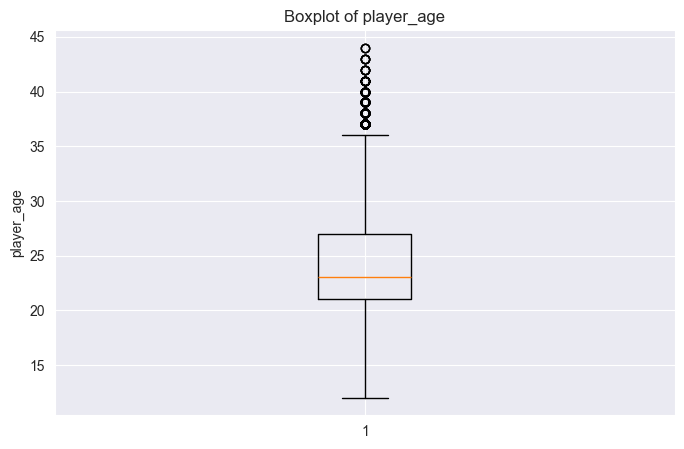

In [19]:
# Select player_age
col = 'player_age'

# Plot
plt.figure(figsize=(8, 5))
plt.boxplot(transfer_df[col], vert=True)
plt.title(f'Boxplot of {col}')
plt.ylabel(col)
plt.show()

Since the boxplot shows a lot of outliers, we looked at the top 20 players with the highest values. Based on our football knowledge, the four players listed make sense to have a high market value. Therefore, we won’t perform any further data cleaning on that column.

In [20]:
# Top 20 player names by market value
col = 'market_val_amnt'

# Sort values in descending order
top20_players = transfer_df.sort_values(by=col, ascending=False).head(20)

# Print
print("Top 20 players by market value:")
print(top20_players['player_name'].to_string(index=False))

Top 20 players by market value:
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
  Kylian Mbappé
 Erling Haaland
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
     Harry Kane
Kevin De Bruyne


We realized while looking at the top 20 players by transfer fee amount that the data doesn’t make sense, as it might be an error in the dataset. We will be deleting all the players with a transfer fee of 500 million, as they all have the same value. After that, the next player is Neymar at 220 million. The one listed at 250 million also seems incorrect, so we’re removing that as well.

In [21]:
# Top 20 transfers
top_20_transfer = transfer_df.sort_values("transfer_fee_amnt", ascending=False).head(20)
print(top_20_transfer["player_name"].to_string(index = False))

         Simone Pesce
    Davide Bertoncini
Massimiliano Tagliani
    Leonardo Cisterni
    Angelo Bencivenga
      Luca Berardocco
   Alessandro Marotta
       Gianluca Curci
         Andrea Cocco
         Simone Pesce
      Andrea Paolucci
        Luca Tedeschi
         Danilo Russo
       Pablo Granoche
     Salvatore Burrai
       Luca Castiglia
    Guglielmo Vicario
       Riccardo Gatti
      Matteo Lombardo
        Mattia Marchi


In [22]:
# Subset for transfer fees less than or equal to 250 million
transfer_df = transfer_df[transfer_df['transfer_fee_amnt'] <= 222000000.0]

In [23]:
# Select transfer_fee_amnt column
col = 'transfer_fee_amnt'

# Select top 20 player with highest transfeer fee
top20_players_fee = transfer_df.sort_values(by=col, ascending=False).head(20)

# Print
print("Top 20 players by transfer fee amount:")
print(top20_players_fee['player_name'].to_string(index=False))

Top 20 players by transfer fee amount:
           Neymar
           Neymar
    Kylian Mbappé
    Kylian Mbappé
  Ousmane Dembélé
Philippe Coutinho
Philippe Coutinho
  Ousmane Dembélé
       João Félix
       João Félix
Antoine Griezmann
Antoine Griezmann
    Jack Grealish
    Jack Grealish
Cristiano Ronaldo
Cristiano Ronaldo
      Eden Hazard
    Romelu Lukaku
      Eden Hazard
    Romelu Lukaku


### Exploratory Data Analysis

To identify meaningful patterns within the dataset and to identify areas of interest to help formulate and develop research questions, we began by exploring how player transfers are distributed across different playing positions and leagues, age distributions across the leagues and lastly we explore the number of transfers and average transfer spending of players across the Leagues.

In [24]:
transfer_df["player_pos"].unique()

['RB', 'CF', 'AM', 'CB', 'CM', ..., 'DM', 'SS', 'RW', 'LM', 'RM']
Length: 13
Categories (13, object): ['AM', 'CB', 'CF', 'CM', ..., 'RB', 'RM', 'RW', 'SS']

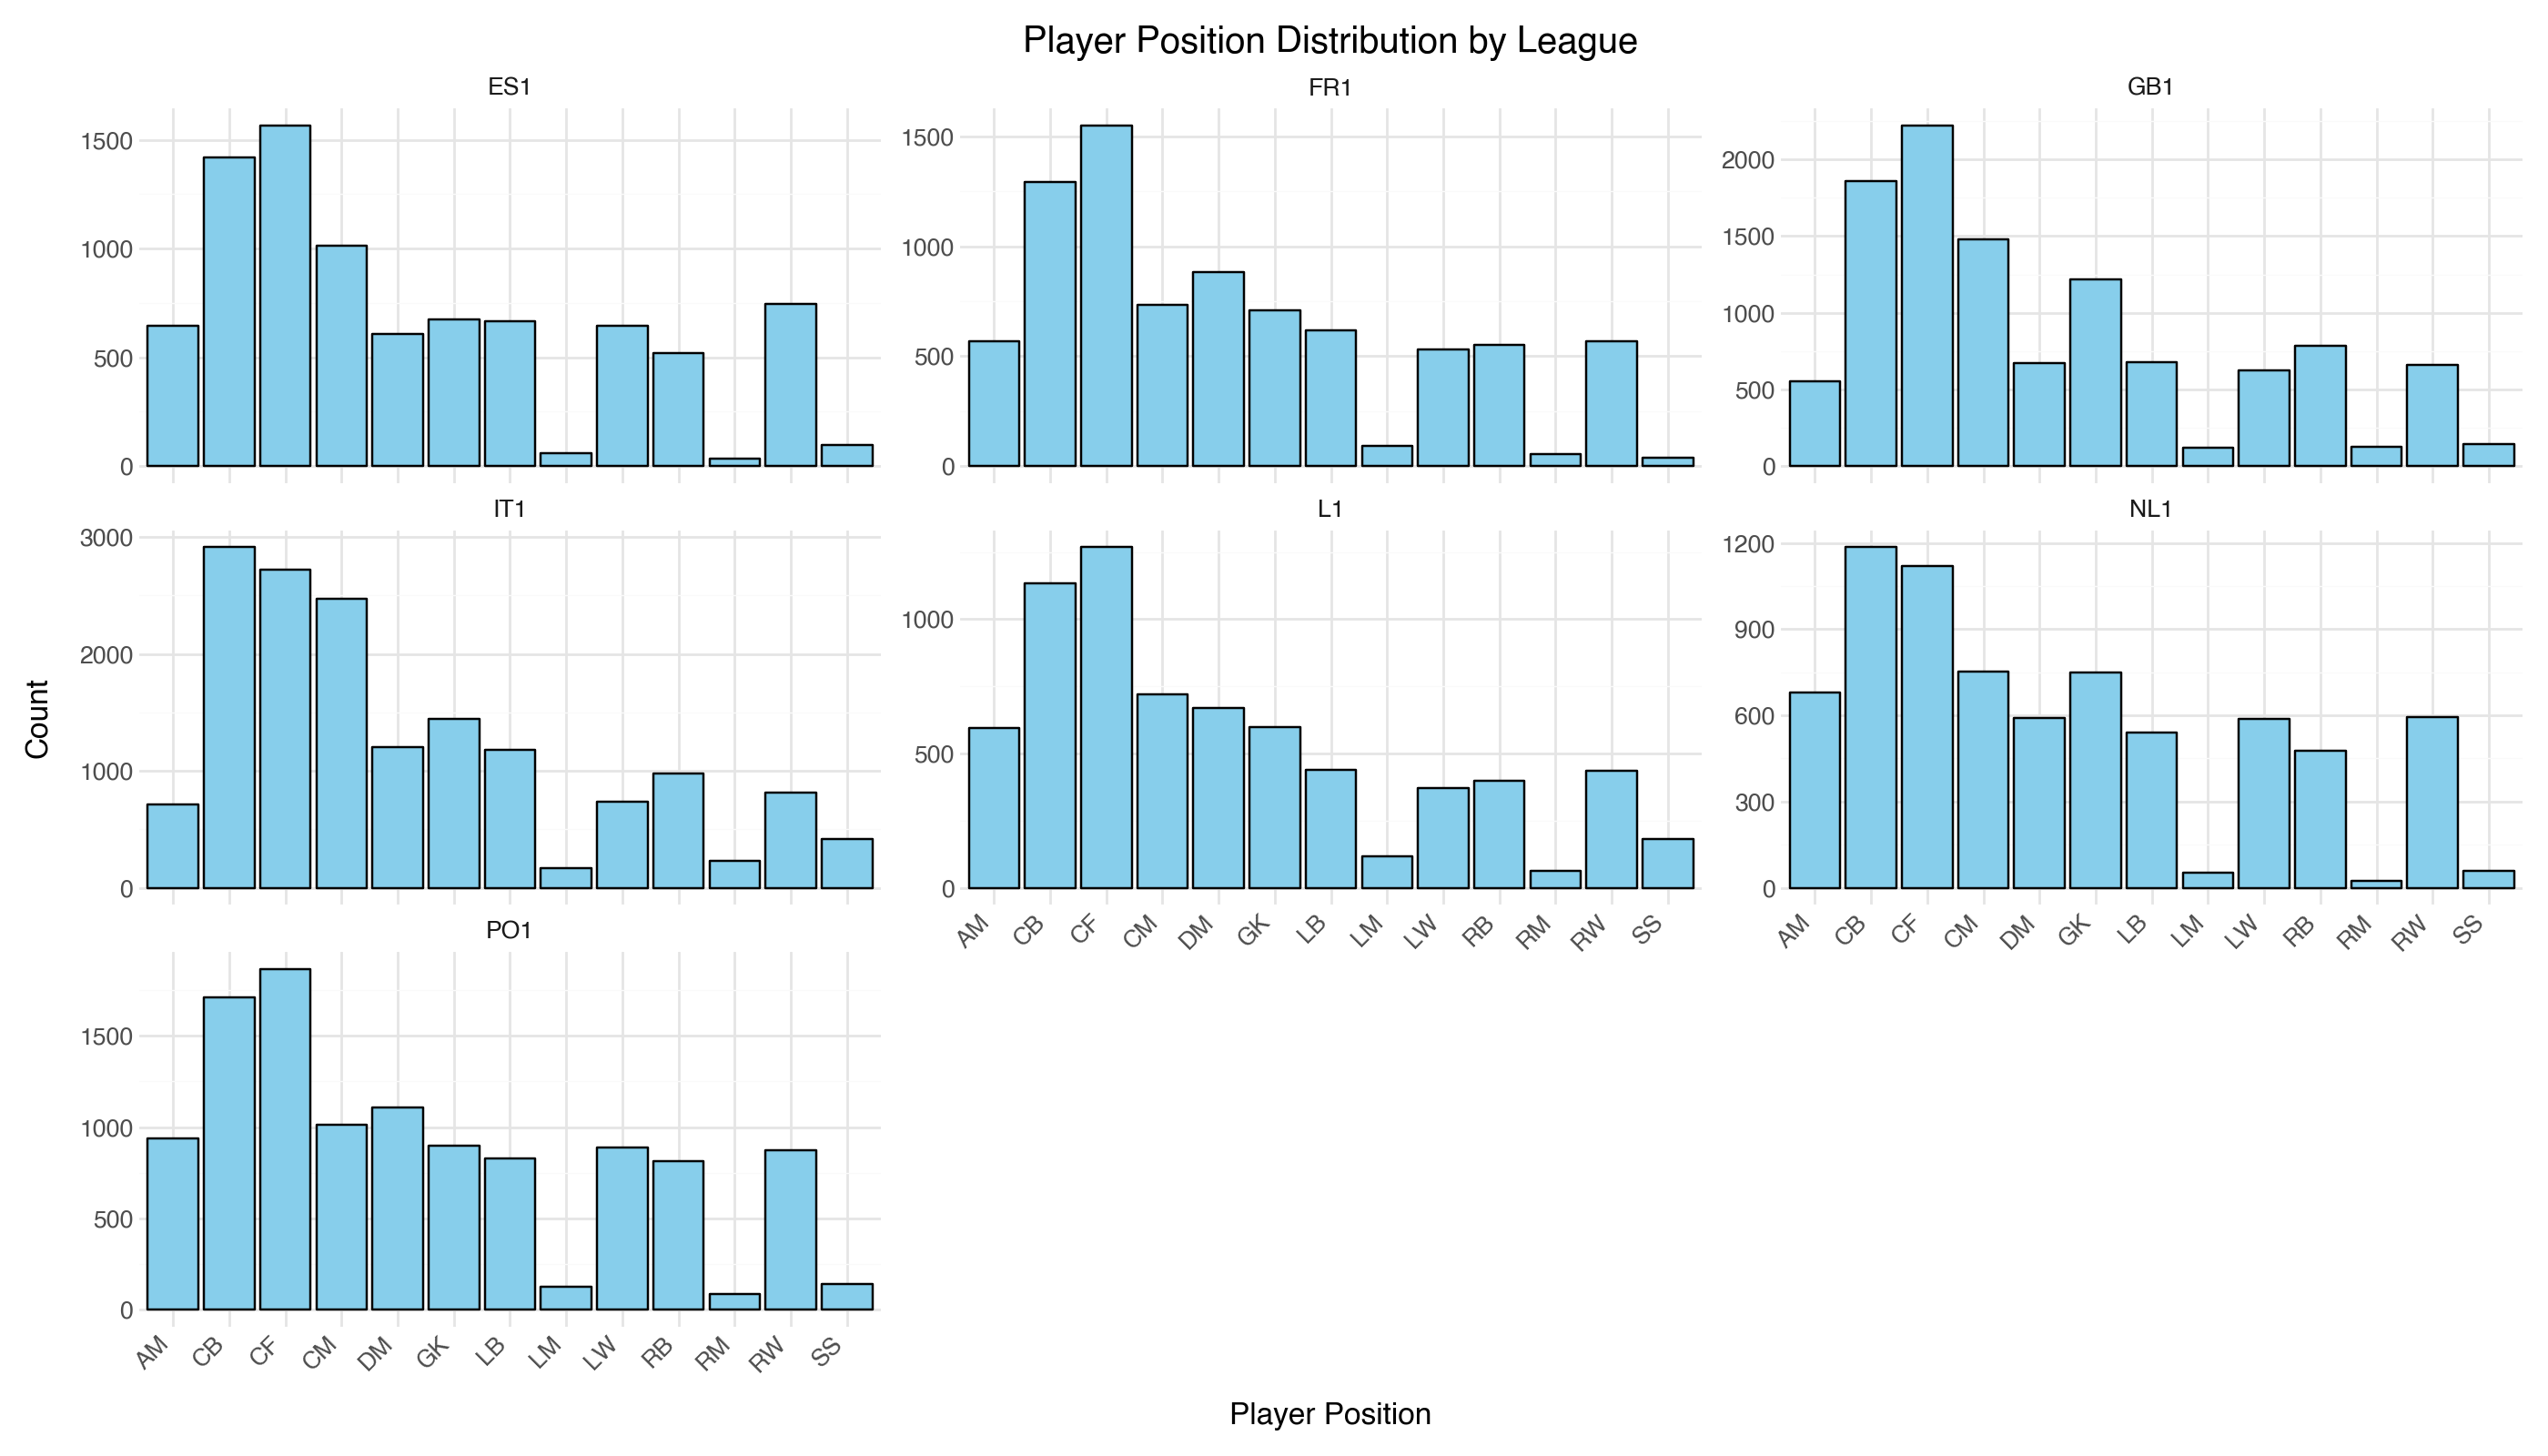

In [25]:
# Prepare data
freq_pos = (
    transfer_df.groupby(["league", "player_pos"], observed=True)
    .size()
    .reset_index(name="count")
    .sort_values("count")
)

# Plot
p = (
    ggplot(freq_pos, aes(x="player_pos", y="count")) +
    geom_bar(stat="identity", fill="#87CEEB", color="black") +
    facet_wrap("~league", scales="free_y", ncol=3) +
    theme_minimal(base_size=12) +
    theme(
        axis_text_x=element_text(rotation=45, ha='right'),
        figure_size=(14, 8),
    ) +
    labs(
        title="Player Position Distribution by League",
        x="Player Position",
        y="Count"
    )
)

p


The above figure shows the distribution of player positions across the six major European leagues. This visualisation shows that across most leagues, central positions such as centre-backs (CB), central midfielders (CM), and centre-forwards (CF) have the highest transfer activity compared to the other positions. The lowest transfer activity can be seen in the LM, RM and SS across the leagues. However, the transfer position activity differs across leagues and in depth analysis will be made in the first research question in this area of interest.

Backup copy for later use.

In [26]:
transfer_df_r = transfer_df.copy()

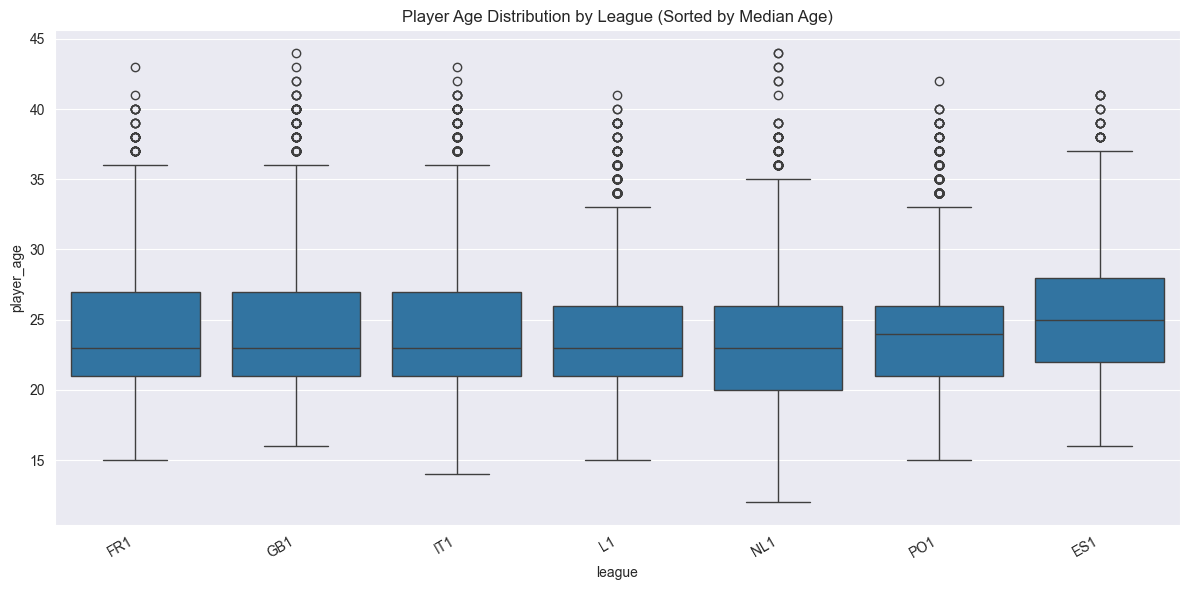

In [27]:
# Create new variable for median player age_distribution across leagues
order = (
    transfer_df.groupby('league', observed=True)['player_age']
    .median()
    .sort_values()
    .index
)

# Plot
plt.figure(figsize=(12,6))
sns.boxplot(
    data=transfer_df,
    x='league', y='player_age',
    order=order,
    showfliers=True
)
plt.title('Player Age Distribution by League (Sorted by Median Age)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

This visualization shows the age distribution across all leagues. The median player age falls between 22 and 25 years, suggesting that transfers predominantly occur during a players prime years. The La Liga (ES1) shows higher median ages compared to the otger leagues of around 25, indicating more transfer activity for more experienced players. In contrast, leagues such as Ligue 1 (FR1) and the Dutch Eredivisie (NL1) display slightly younger distributions of around 23 years. The Visualisation also shows outliers across all the leagues, mostly above the age of 35 for most leagues. The assumption is that this represents veteran players who remain active in the transfer market either through free or low-fee transfers late in their careers. Observing these patterns led to an interest in deeper investigation into how player age, transfer type, and league characteristics combined influence transfer spending, number of transfer activity and performance outcomes leading to the second research  question.

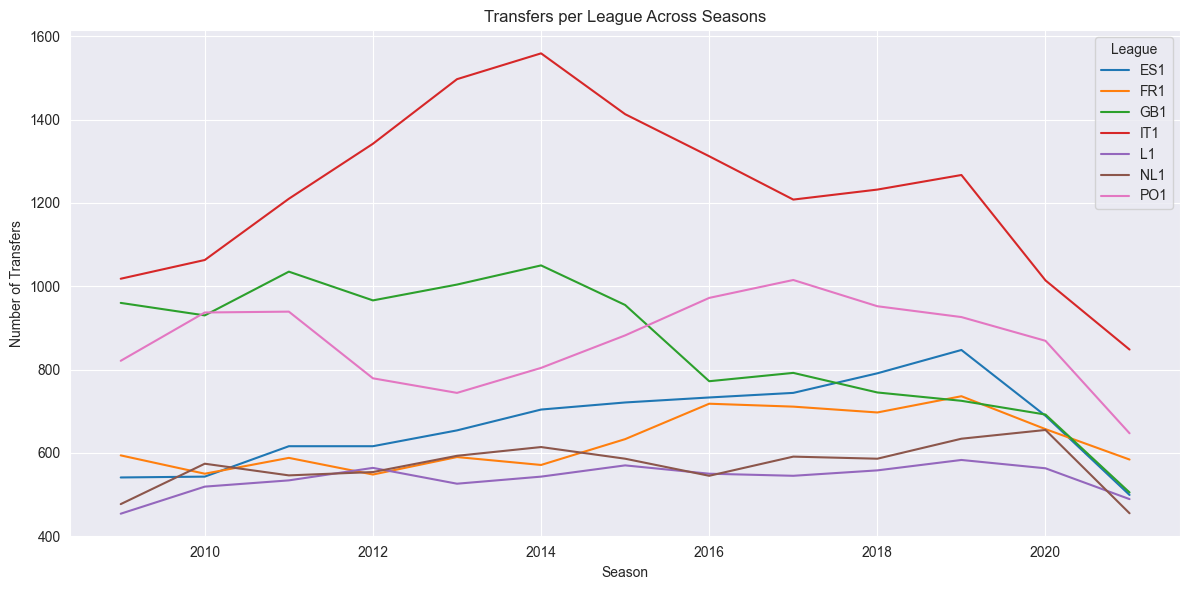

In [28]:
# Creating a pivot table for the Number of transfers per league over the seasons
pivot = transfer_df.pivot_table(index = "season",
                                columns = "league",
                                values = "transfer_id",
                                aggfunc = "count",
                                observed= False)

# Plot
pivot.plot(figsize = (12,6))
plt.title("Transfers per League Across Seasons")
plt.xlabel("Season")
plt.ylabel("Number of Transfers")
plt.legend(title = "League")
plt.tight_layout()
plt.show()

This visualisation illustrates transfer activity across major European leagues between 2009 and 2021. The line graph presents the total number of transfers across the season for each league. The graph shows a clear upward trend in most leagues during the early 2010s, reaching a peak between 2014 and 2016, before a decrease, especially from 2019 on wards. Serie A (IT1) consistently shows the highest number of transfers throughout the seasons. The Premier League (GB1) maintained high activity till 2014 where it decreased till 2016, then decreased gradually till a shard decline from 2020. La Liga (ES1) and Ligue 1 (FR1) show less transfer activity from 2009 till 2016 where it increased gradually then decreased from 2019, while the remaining leagues exhibit smaller steady volumes.

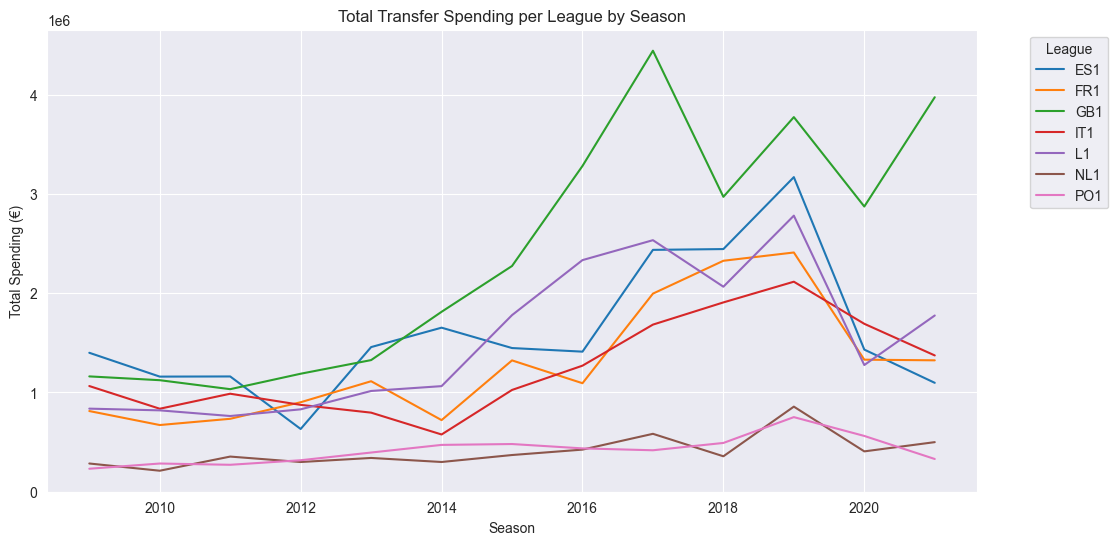

In [29]:
# Average Transfer Spending per League per Season
pivot_spending = transfer_df.pivot_table(
    index = "season",
    columns = "league",
    values = "transfer_fee_amnt",
    aggfunc = "mean",
    observed = False
)

# Plot
pivot_spending.plot(figsize = (12,6))
plt.title("Total Transfer Spending per League by Season")
plt.xlabel("Season")
plt.ylabel("Total Spending (€)")
plt.legend(title = "League", bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

This graph shows the total transfer spending across major European leagues from 2009 to 2021. The Premier League (GB1) consistently exhibits the highest levels of transfer expenditure where the transfer spending in the Premier League increased sharply after 2013, peaking around 2017, before a declining and remaining fairly stable across the remaining years. La Liga (ES1), Ligue 1 (FR1), Bundesliga (L1) and Serie A (IT1) show similar upward trajectories, with spending peaks in 2019, suggesting major signings in both Spain and Italy. On the other hand, the Dutch Eredivisie (NL1) and Liga Portugal Bwin (PO1) maintain low total spending throughout.

### Research Question 1: Transfer patterns throughout the leagues (All leagues)
This research question examines player transfers across multiple leagues and seasons, focusing on player origins, transfer fees, and club spending behavior. It explores patterns in nationality and position dominance, tracks how much clubs invest in specific windows, and analyzes spending trends across different transfer windows and years. (Top 4 Position, CB, CF, CM, GK, amount of money spent in each League, differences?)

As we have seen previously, Centre Backs (CB), Centre Forwards (CF), Centre Midfielders (CM) and Goalkeepers (GK) were transferred most often in transfer history. In this research question we will focus on these four positions for our further analysis. In order to be able to cleanly analyze the data, we first do some more data cleaning and preparing in the following code section.

In [30]:
#check whether a column with players simplified already exists, if not, create it
#we also define the top 4 positions as stated in research question number 1
if 'player_pos_simplified' not in transfer_df.columns:
    top_positions = {'CB', 'CF', 'CM', 'GK'}
    #convertig all positions to uppercase, removing extra spaces (just in case) and check if position is in top_positions set defined above
    #if yes, keeps it, if no adds it to category: "Other"
    transfer_df['player_pos_simplified'] = (
        transfer_df['player_pos'].str.upper().str.strip().where(
            lambda s: s.isin(top_positions), 'Other'))

In [31]:
#check if creating new simplified column has worked
transfer_df['player_pos_simplified'].head(10)

0    Other
1       CF
2    Other
3       CF
4       CB
5       CF
6       CB
7       CB
8       CM
9       GK
Name: player_pos_simplified, dtype: object

In [32]:
#first, make a copy of df_transfer, to safely analyze and not mess with the original dataset
df = transfer_df.copy()

#we group by league and season, creating a simplified table
league_season = (
    df.groupby(['league', 'season'], observed=False)
      .agg(
          total_spend=('transfer_fee_amnt', 'sum'),
          deals=('transfer_fee_amnt', 'count'),
          avg_fee=('transfer_fee_amnt', 'mean'))
      .reset_index()
      .sort_values(['league', 'season']))

league_season.head()

,league,season,total_spend,deals,avg_fee
0,ES1,2009,756925000.0,541,1.399122e+06
1,ES1,2010,629250000.0,543,1.158840e+06
2,ES1,2011,714845000.0,616,1.160463e+06
3,ES1,2012,388600000.0,616,6.308442e+05
4,ES1,2013,952580000.0,654,1.456544e+06


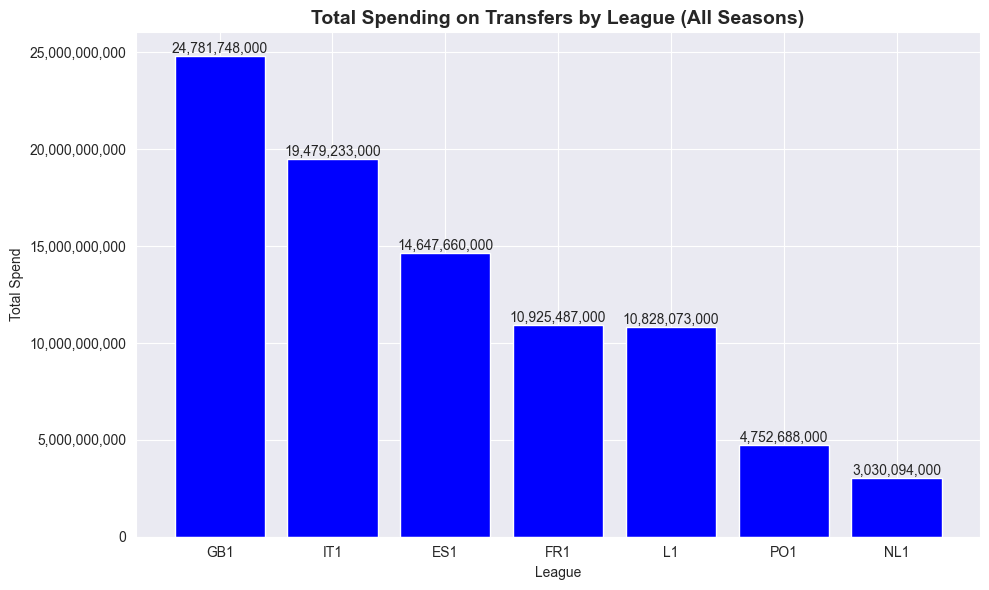

In [33]:
#group and sort
league_totals = (
    league_season
    .groupby('league', observed=False)['total_spend']
    .sum()
    .sort_values(ascending=False)
    .reset_index())

#plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(league_totals['league'], league_totals['total_spend'], color='blue')

#add some value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}',
            ha='center', va='bottom', fontsize=10)

#axis labels and formatting
ax.set_title('Total Spending on Transfers by League (All Seasons)', fontsize=14, weight='bold')
ax.set_xlabel('League')
ax.set_ylabel('Total Spend')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

#show plot
plt.tight_layout()
plt.show()

As we can see, the english Premier League and the italian Serie A spent the most amount of money on transfers throughout all seasons. Now we want to see the total spend per season per league. For that we choose the 4 leagues with the highest spending (Premier League, Serie A, La Liga and Ligue 1).

In [34]:
#calculate the total spending per league across all seasons
league_totals = (
    league_season
    .groupby('league', observed=False)['total_spend']
    .sum()
    .reset_index()
    .sort_values('total_spend', ascending=False))

#data selection
top4 = league_totals['league'].head(4).tolist()
trend_top = league_season[league_season['league'].isin(top4)]

#adding interactiveness by using plotly package
fig = px.line(
    trend_top,
    x='season',
    y='total_spend',
    color='league',
    markers=True,
    title='Total Spending per Season (Top Leagues)',
    hover_data=['league', 'season', 'total_spend'])

fig.show()

The following code helps us display the interactive plots, as we encountered some issues when running the code in different IDEs.

In [35]:
#calculate the total spending per league across all seasons
league_totals = (
    league_season
    .groupby('league', observed=False)['total_spend']
    .sum()
    .reset_index()
    .sort_values('total_spend', ascending=False))

#data selection
top4 = league_totals['league'].head(4).tolist()
trend_top = league_season[league_season['league'].isin(top4)]

#adding interactiveness by using plotly package
fig = px.line(
    trend_top,
    x='season',
    y='total_spend',
    color='league',
    markers=True,
    title='Total Spending per Season (Top Leagues)',
    hover_data=['league', 'season', 'total_spend'])

fig.show()

As we can see, from the year 2014 on, in almost all top 4 leagues, spending has increased (except La Liga until 2016). The English Premier League having its highest spending year in 2017. Premier League, Serie A and La Liga have spent more or less the same amount on transfers in the year 2019, as the points are almost at an identical position, whereas Ligue 1 consistently spends lower amounts than the other three. All 4 leagues have a major dip in spending during 2019-2020 and onwards. We want to analyze the spending a bit more. Therefore we analyze the size of the deals and numbers of transfers made.

In [36]:
#creating dir_clean
df['dir_clean'] = (
    df['dir'].astype(str).str.strip().str.lower()
    .replace({'in': 'incoming', 'left': 'left'}))

#focusing on money spent (incoming transfers) and not outgoing transfers
df_in = df[df['dir_clean'] == 'incoming']

#grouping the data by league and season to calculate total spending, number of deals and average fee per deal
league_season = (
    df_in.groupby(['league','season'], observed=False)
         .agg(
             total_spend=('transfer_fee_amnt','sum'),
             deals=('transfer_fee_amnt','count'),
             avg_fee=('transfer_fee_amnt','mean'))

         .reset_index()
         .sort_values(['league','season']))

#summarizing per league across all seasons
#mean_avg_fee = typical average price per player
#mean_deals = number of deals made on average per season
#total_spend = total money spent
mix_df = (
    league_season.groupby('league', observed=False)
                 .agg(
                     mean_avg_fee=('avg_fee','mean'),
                     mean_deals=('deals','mean'),
                     total_spend=('total_spend','sum'))

                 .reset_index()
                 .sort_values('total_spend', ascending=False))
mix_df

,league,mean_avg_fee,mean_deals,total_spend
2,GB1,3.235327e+06,427.615385,1.650046e+10
3,IT1,2.248425e+06,370.692308,1.041704e+10
0,ES1,1.685807e+06,337.153846,7.735250e+09
4,L1,1.645699e+06,272.692308,5.898743e+09
1,FR1,1.266201e+06,318.076923,5.406983e+09
6,PO1,2.587926e+05,436.230769,1.470655e+09
5,NL1,2.358499e+05,285.769231,8.849120e+08


As we can see, the Premier League dominates the total spending, ahead of Italy and Spain. Portugal and Netherlands have much lower totals, reflecting smaller markets. Also the average fee (investment per player) is the highest in the Premier League, following Italy and Spain again. England, Italy, and Spain pursue high-value deals, while smaller leagues could focus on talent development more often. Portugal and England show the highest activity with around 400 deals per season. High deal counts in combination with low fees suggest a volume-based market (Portugal). Whereas Ligue 1 (France) makes more targeted and high-value investments (low deal counts plus high player fees).

Let us now focus on patterns and analysis regarding nationalities.

In [37]:
#we count the incoming players by league and nationality
nationality_league = (
    df_in.groupby(['league', 'player_nation'], observed=False)['player_name']
    .count()
    .reset_index(name='count')
    .sort_values(['league', 'count'], ascending=[True, False]))

#show the top 5 nationalities per league
top5_nationalities = (
    nationality_league.groupby('league', observed=False)
                      .head(5))

top5_nationalities

,league,player_nation,count
142,ES1,Spain,2260
6,ES1,Argentina,290
19,ES1,Brazil,216
125,ES1,Portugal,158
54,ES1,France,119
222,FR1,France,1750
303,FR1,Senegal,197
187,FR1,Brazil,145
204,FR1,Cote d'Ivoire,136
265,FR1,Mali,119


We can see, that each league has different scouting identities. The Premier League and Serie A display somewhat a high international diversity pattern, whereas the spanish league and the portuguese league are having deep ties with South America.
For Ligue 1 in France, we can see that they have an extensive African scouting network, while Germany and the Netherlands rely heavily on regional European talent.
It shows historical, linguistic, cultural and economic connections throughout the different transfer patterns in the different leagues.

See also the visualisations of the top countries below.

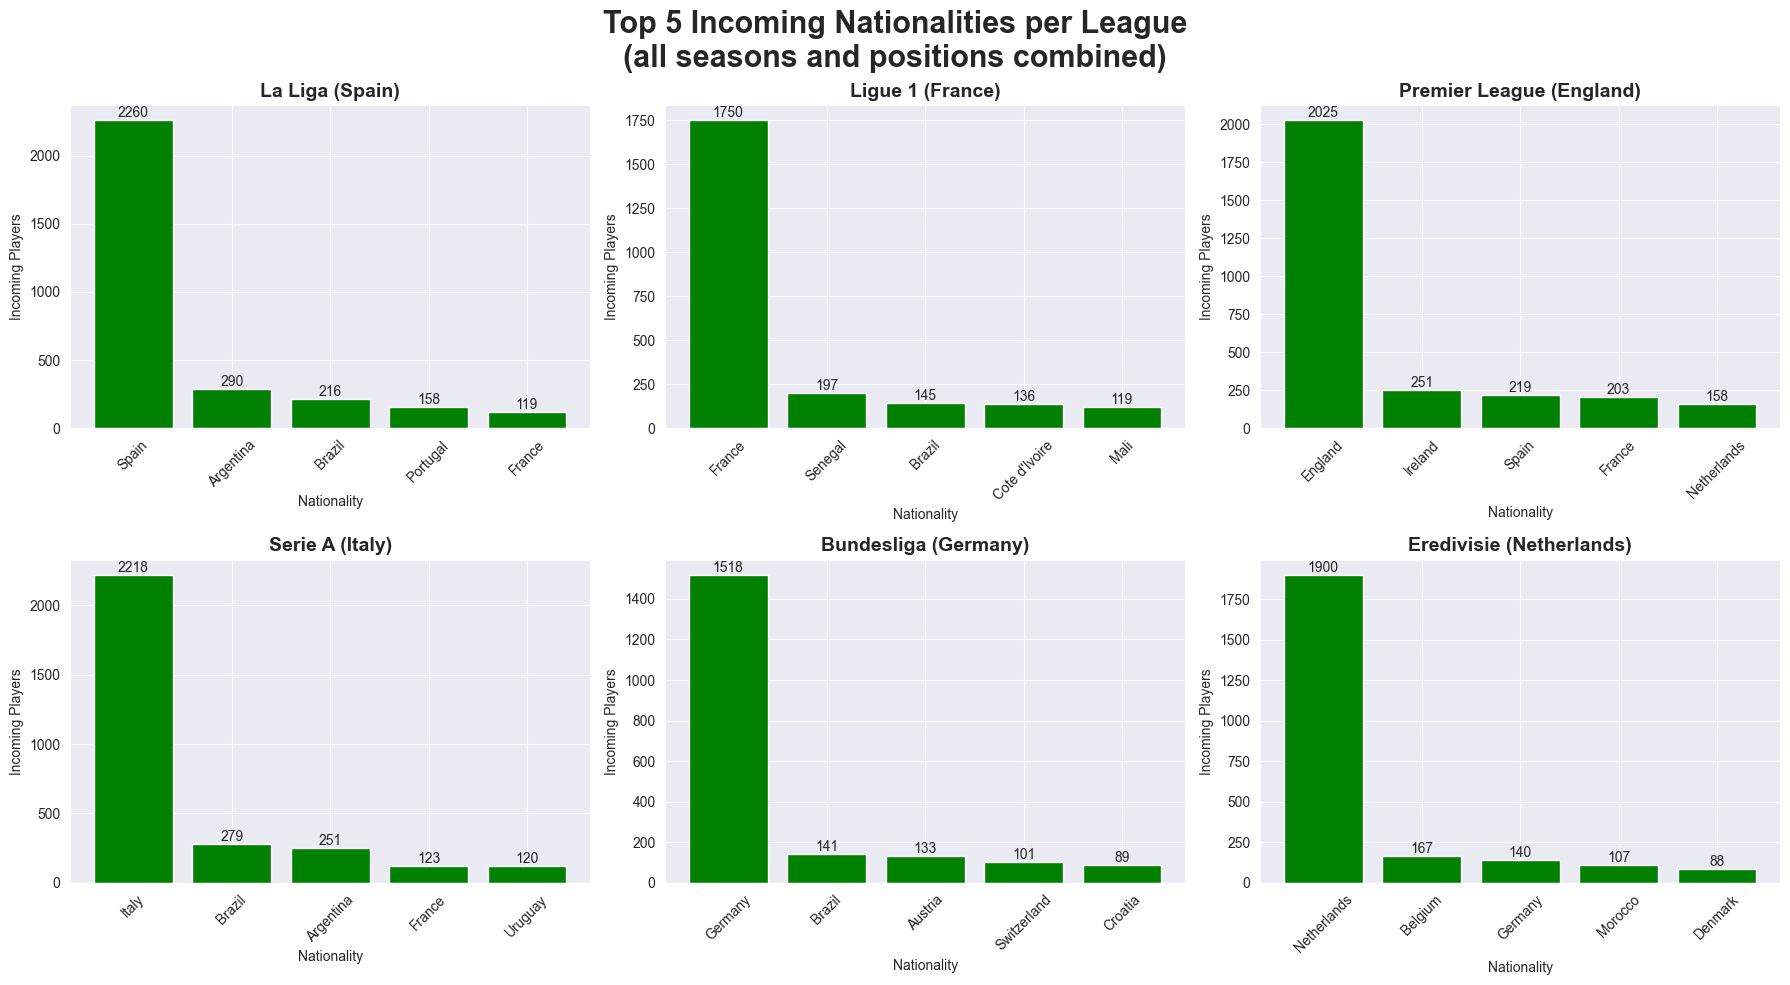

In [38]:
#defining clear league names
league_names = {
    'ES1': 'La Liga (Spain)',
    'GB1': 'Premier League (England)',
    'IT1': 'Serie A (Italy)',
    'FR1': 'Ligue 1 (France)',
    'PO1': 'Primeira Liga (Portugal)',
    'NL1': 'Eredivisie (Netherlands)',
    'L1': 'Bundesliga (Germany)'}

#unique leagues
leagues_unique = top5_nationalities['league'].unique()

#set up subplots 2x3 (for 6 leagues)# keep your existing 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, lg in enumerate(leagues_unique[:6]):  # <- limit to 6
    subset = top5_nationalities[top5_nationalities['league'] == lg]
    ax = axes[i]
    bars = ax.bar(subset['player_nation'], subset['count'], color='green')
    ax.set_title(league_names.get(lg, lg), fontsize=14, weight='bold')
    ax.set_xlabel("Nationality"); ax.set_ylabel("Incoming Players")
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        v = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, v, f"{int(v)}", ha='center', va='bottom', fontsize=10)

fig.suptitle("Top 5 Incoming Nationalities per League\n(all seasons and positions combined)",
             fontsize=22, weight='bold')
plt.tight_layout()
plt.show()

Now we want to combine the top player positions CB, CF, CM and GK with nationalities, by asking, which nationality fills which positions the most across all leagues.

In [39]:
#count how many players of each nationality play each position
pos_nationality = (
    df_in.groupby(['player_pos_simplified', 'player_nation'], observed=False)['player_name']
         .count()
         .reset_index(name='count')
         .sort_values(['player_pos_simplified','count'], ascending=[True, False]))

#get top 5 nationalities per position
top_nat_per_pos = pos_nationality.groupby('player_pos_simplified', observed=False).head(5)
top_nat_per_pos


,player_pos_simplified,player_nation,count
19,CB,Brazil,469
110,CB,Netherlands,440
54,CB,France,426
142,CB,Spain,410
78,CB,Italy,406
246,CF,Italy,457
310,CF,Spain,454
187,CF,Brazil,404
216,CF,England,397
222,CF,France,354


We can see that Brazilian and Italian players mostly dominate attacking positions, bringing technical flair and attacking power. European nations such as Italy and England remain strong in goalkeeping and more defensive roles. Central and defensive positions are mainly filled by African players, especially from France and the Netherlands. Furthermore, we can also see, that most player filling the top positions, come from European countries such as Italy, England, France, Spain and Germany. Which also represents each top nationalities in each league, which we have seen above.

We created a heatmap to showcase how often players of a specific nationality appeared among the top 5 nationalities per position across all incoming transfers. The rows show the Nationality, the columns show the player positions (CB, CF, CM, GK and Other). The cell values indicate the number of incoming players in the league vs. position combination.

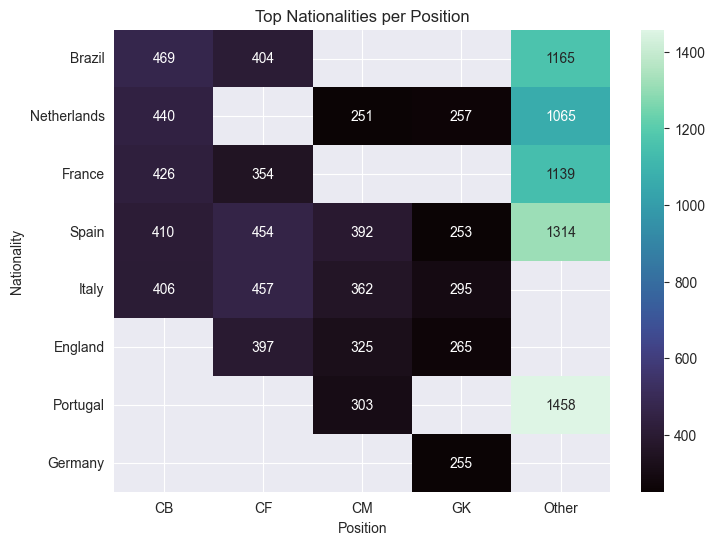

In [40]:
#pivot the data
heatmap_data = (
    top_nat_per_pos.pivot(
        index='player_nation',
        columns='player_pos_simplified',
        values='count'))

#plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='mako')
plt.title('Top Nationalities per Position')
plt.xlabel('Position')
plt.ylabel('Nationality')
plt.show()

Empty cells indicate nationality-positions that did not rank among the top five nationalities for that position. They do not imply zero players, but simply fall outside the top 5 threshold used. Spain and Italy consistently appear across all core positions (top 4), with Spain leading in CFs and Italy in CBs. Brazil also shows strong presence in CB and CF positions, along with a high count of "Other", suggesting a mixed wide range of positions beyond the 4 core roles. Portugal has the highest number of "Other" player category, indicating that many players in non-central roles such as wingers or fullbacks. Germany only appears in GK, indicating a specialized presence in that category of player position.

To further analyze, we looked at the positional spending per position.

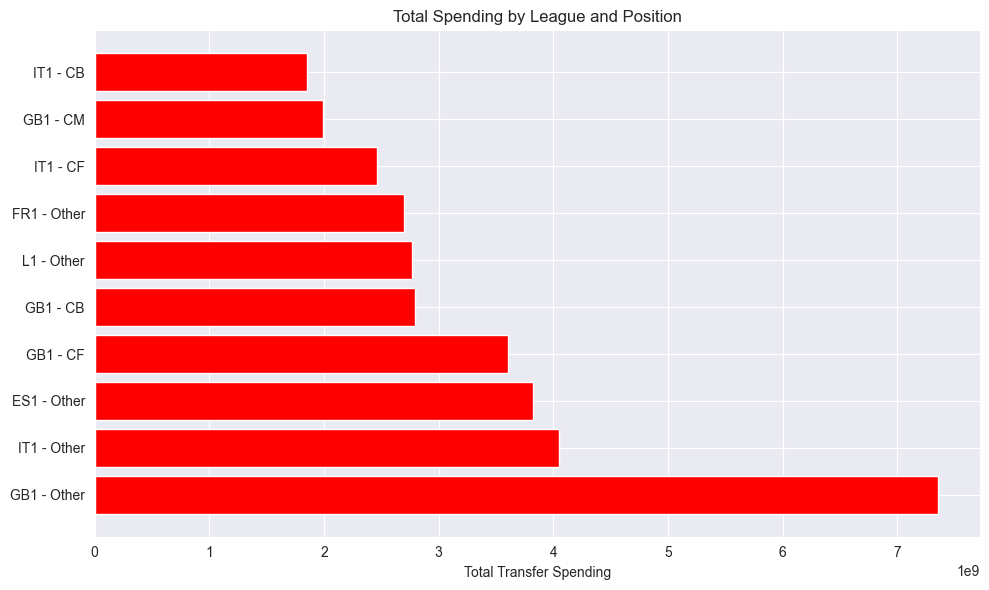

In [41]:
pos_spend = (
    df_in.groupby(['league', 'player_pos_simplified'], observed=False)['transfer_fee_amnt']
         .agg(['sum','mean','count'])
         .reset_index()
         .rename(columns={'sum':'total_spent','mean':'avg_fee','count':'num_transfers'}))

pos_spend_sorted = pos_spend.sort_values('total_spent', ascending=False).head(10)

#plot as a horizontal barplot
plt.figure(figsize=(10,6))
plt.barh(
    pos_spend_sorted['league'].astype(str) + " - " + pos_spend_sorted['player_pos_simplified'].astype(str),
    pos_spend_sorted['total_spent'],
    color='red')

plt.xlabel('Total Transfer Spending')
plt.title('Total Spending by League and Position')
plt.tight_layout()
plt.show()

The positionals spending analysis reveals differences in how leagues allocate resources. The english Premier League dominates in overall spending (as we have seen), particularly for forwards (CF) and defenders (CB). Showcasing that there is an emphasis on fast attacking power, but also defensive solidity.

Serie A and La Liga show a balanced investment across positions. Could be that they focus more on the development of players and on player sales, rather than making big investments.
Across all positions, forwards and centre-backs represent the highest value positions. This goes hand in hand with the financial premium set on goalscoring and defensive reliability.

To better showcase the average fees paid per position, we plotted the respective values below.

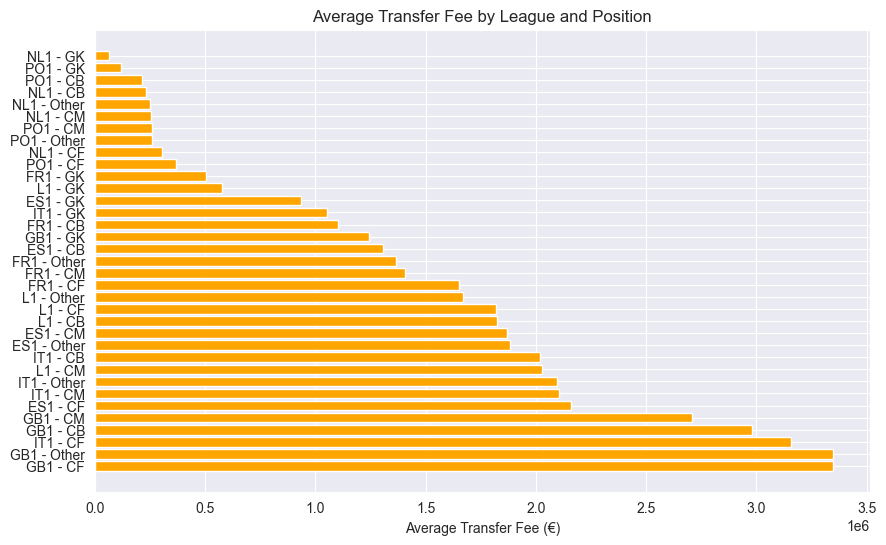

In [42]:
#sort by average fee
pos_spend_avg_sorted = pos_spend.sort_values('avg_fee', ascending=False)
pos_spend_avg_sorted['league_pos'] = (
    pos_spend_avg_sorted['league'].astype(str) + " - " + pos_spend_avg_sorted['player_pos_simplified'].astype(str))

#plot average fee
plt.figure(figsize=(10,6))
plt.barh(pos_spend_avg_sorted['league_pos'], pos_spend_avg_sorted['avg_fee'], color='orange')
plt.xlabel('Average Transfer Fee (€)')
plt.title('Average Transfer Fee by League and Position')
plt.show()

For example, in the Premier League, clubs spend on average 3.25 to 3.3 Mio. per striker. This is the highest among all leagues and positions. Mentioned before, this reflects the premium on goal-scoring ability.

Note: The "Other" category includes all positions outside the top 4 roles. This category appears often, which indicates that these roles are both frequent in number (merges a lot of different roles, therefore the sample size is big), but also strategically valuable. Wingers (LW and RW), which are amongst the most expensive positions and Attacking Midfielders with their creative play style, are often premium transfers, where clubs making a huge investment.

To investigate whether certain positions (Attacking vs. Defending Positions) command higher transfer fees, we also compared the fees of Centre Forwards (CFs) and Centre Backs (CBs) using an independent samples t-test.

In [43]:
cf_fees = df_in[df_in['player_pos_simplified'] == 'CF']['transfer_fee_amnt'].dropna()
cb_fees = df_in[df_in['player_pos_simplified'] == 'CB']['transfer_fee_amnt'].dropna()

t_stat, p_val = stats.ttest_ind(cf_fees, cb_fees, equal_var=False)
print(f"T = {t_stat:.4f}, p = {p_val:.4f}")

T = 4.0322, p = 0.0001


The results indicate a statistically significant difference (T = 4.0322, p = 0.0001), suggesting that CFs are consistently more expensive than CBs across the top European leagues.

### Research Question 2: “How do transfer market dynamics particularly player age, transfer type, and league characteristics influence the number of transfer activity, transfer spending patterns and their relationship with team performance across major European football leagues and seasons, and how do these patterns differ across age groups and transfer directions?”

 This research investigates how transfer market dynamics such aas player age, transfer type, and league characteristics influence transfer spending patterns and their relationship with team performance across major European football leagues with a focus on mainly the Premier League, La Liga and Italian League across seasons from 2009 to 2021. The research will examine how different leagues balance between developing, selling and acquiring players of different age groups, and how these trends evolve over time. The study further explores which factors, such as player age, market value, and transfer type, explain variations in the likelihood and value of player age groups (mainly prime and youth players) transfers. Finally, the analysis assesses the broader impact of player transfer activity on league development, focusing on whether higher player transfer rates contribute to greater competitive performance across leagues and player groups over time.

### 1. Exploratory Data Analysis

## 1. 1 Grouping Ages: Youth, Prime & Veteran

To begin the analysis, We first grouped players into three categories: youth (≤23 years), prime (24–29 years), and veteran (≥30 years) using a simple function. After grouping, I calculated the average transfer fee per age group and visualized the results using a bar chart to identify clear differences between player age and transfer fees, allowing me to identify which age category clubs invest in most and how player value changes over a footballer’s career.

In [44]:
# Group data into youth and veterans
def category_age(age):
    if age <= 23:
        return "youth"
    elif age <= 29:
        return "prime"
    else:
        return "veteran"

# Apply function
transfer_df["age_group"] = transfer_df["player_age"].apply(category_age)
transfer_df["age_group"].value_counts()

age_group
youth      35700
prime      25319
veteran     8665
Name: count, dtype: int64

In [45]:
transfer_df.info()
transfer_df["dir"].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 69684 entries, 0 to 70005
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   league                 69684 non-null  category
 1   season                 69684 non-null  int64   
 2   window                 69684 non-null  category
 3   team_id                69684 non-null  int64   
 4   team_name              69684 non-null  category
 5   team_country           69684 non-null  category
 6   dir                    69684 non-null  category
 7   player_id              69684 non-null  int64   
 8   player_name            69684 non-null  object  
 9   player_age             69684 non-null  Int64   
 10  player_nation          69684 non-null  category
 11  player_pos             69684 non-null  category
 12  counter_team_id        68949 non-null  Int64   
 13  counter_team_name      69684 non-null  category
 14  counter_team_country   69684 non-null  cate

['in', 'left']
Categories (2, object): ['in', 'left']

In [46]:
transfer_df

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id,player_pos_simplified,age_group
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23,...,England,18800000.0,0.0,False,False,False,False,310832,Other,youth
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21,...,Norway,4500000.0,1600000.0,False,False,False,False,319841,CF,youth
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20,...,France,4000000.0,400000.0,False,False,False,False,315185,Other,youth
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29,...,England,0.0,0.0,True,False,False,False,306421,CF,prime
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18,...,England,0.0,0.0,False,False,False,False,339015,CB,youth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70001,NL1,2021,w,306,SC Heerenveen,Netherlands,in,257808,Runar Espejord,25,...,Norway,0.0,500000.0,False,True,True,False,3071862,CF,prime
70002,NL1,2021,w,306,SC Heerenveen,Netherlands,in,580142,Joaquín Fernández,22,...,Uruguay,0.0,100000.0,False,True,True,False,3268245,CB,youth
70003,NL1,2021,w,468,Sparta Rotterdam,Netherlands,in,340353,Maduka Okoye,22,...,England,0.0,1000000.0,False,True,False,False,3619917,GK,youth
70004,NL1,2021,w,468,Sparta Rotterdam,Netherlands,left,340353,Maduka Okoye,22,...,England,7000000.0,1000000.0,False,False,False,False,3619916,GK,youth


In [47]:
# Aggregate the average transfer fees per age group
avg_fees = (
    transfer_df.groupby("age_group", observed=False)["transfer_fee_amnt"]
    .mean()
    .reset_index()
)

# Plot
fig1 = px.bar(
    avg_fees,
    x="age_group",
    y="transfer_fee_amnt",
    color="age_group",
    text=avg_fees["transfer_fee_amnt"].apply(lambda x: f"€{x:,.0f}"),
    title="Average Transfer Fee by Age Group",
    labels={"transfer_fee_amnt": "Average Transfer Fee (€)", "age_group": "Age Group"},
    template="plotly_dark"
)

fig1.update_traces(textposition="outside")
fig1.update_layout(showlegend=False, yaxis_type="log")
fig1.show()

The bar plot shows the difference in average transfer fees between the age groups. Prime-age players of ages ranging 24–29 years old have the highest average transfer fees  of about €1.76 million (M). Youth players on the other hand of ages 23 years old or less, still have a high transfer fee around €1.09 M, reflecting the premium clubs pay for future potential. Veterans who are players older than 30 are far cheaper roughly around €0.56 M, we can see in the graph that the lowest average transfer fees.

After observing clear differences in transfer fees in player age groups, we wanted to explore how transfer fees changes with player age and whether certain leagues place higher financial emphasis on specific age groups. This led to the visualization of average transfer fees by age category across leagues.

In [48]:
# Aggregating Age group on League level to compare the average transfer fees across the league
avg_fees_league = (
    transfer_df.groupby(["league", "age_group"], observed=False)["transfer_fee_amnt"]
    .mean()
    .reset_index()
)

# Plot
fig2 = px.bar(
    avg_fees_league,
    x="age_group",
    y="transfer_fee_amnt",
    color="league",
    barmode="group",
    text=avg_fees_league["transfer_fee_amnt"].apply(lambda x: f"€{x:,.0f}"),
    title="Average Transfer Fee by Age Group and League",
    labels={"transfer_fee_amnt": "Average Transfer Fee (€)", "age_group": "Age Group"},
    template="plotly_dark"
)
fig2.update_traces(textposition="outside")
fig2.update_layout(yaxis_type="log")
fig2.show()

This diagram shows the difference in league spending for players at different age groups. The Premier League (GB1) pays high transfer fees across all age groups, with the highest average transfer fees in the prime (around €4M) and youth age groups (around €1.5M). This confirms the Premier League’s financial dominance and spending power compared to other European leagues.
La Liga (ES1) and Serie A (IT1) also show moderately high spending across all the age groups. The serie A shows the highest average transfer fees for veterans (around €0.8M), suggesting more value placed on experienced players in the Serie a whereas the La Liga shows the highest average transfer fee for youth players around €1.6M.

### 1.2 Statistical Analysis to identify whether league or Age group has a significant effect on transfer fees

After observing differences in transfer fee across leagues and age groups from the earlier exploratory visualizations, the next logical step for us was to statistically test whether these observed differences were significant rather than random variations. To achieve this, we performed a two-way ANOVA (Analysis of Variance) to examine the main effects of league and age group on transfer fees and their interaction effect. We used a two-way ANOVA rather than a simple comparison test t-test or One-Way Anova because we were testing multiple categorical variables and determine whether the effect of player age on transfer fees varied across leagues.

In [49]:
anova_model = ols("transfer_fee_amnt ~ C(league) + C(age_group) + C(league):C(age_group)", data=transfer_df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                              sum_sq       df           F         PR(>F)
C(league)               2.761374e+16      6.0  154.936518  3.124018e-196
C(age_group)            1.327115e+16      2.0  223.387260   1.967529e-97
C(league):C(age_group)  1.212328e+16     12.0   34.010941   1.264463e-79
Residual                2.069295e+18  69663.0         NaN            NaN


The two-way ANOVA tested whether average transfer fees differ significantly by league, age group, and their interaction.
League effect (F = 154.94, p < 0.001) shows that the transfer fees vary significantly across leagues, confirming that financial strength differs massively between the leagues. Age group effect (F = 223.39, p < 0.001) shows that the transfer fees also vary much by player age. Interaction effect (F = 34.01, p < 0.001)  shows the impact of age group on transfer fees depends on the league, meaning some leagues pay proportionally more for youth or prime players than others.

## YOUTH PLAYERS

### 2.  OUTGOING YOUTH PLAYERS

## 2. 1 Prepare Data for Analysis for Youth Players Leaving the Leagues

After identifying that both league and age group significantly influence transfer fees, we decided to narrow the scope of our analysis to youth players leaving their leagues. We found this interesting because it shows the developmental and financial strategies of leagues whether they prioritize nurturing and exporting young talent or retaining them for long-term growth.
This would help us analyze export behavior better.

The data preparation process focused converting the is_free variable into numeric format allowed for easier quantitative modeling of free or paid transfers, converting categorical variables like team_country and counter_team_country into strings ensured smooth comparisons across leagues (although this wasnt used for analysis due to time constraints). We also created the transfer_type variable (domestic vs. international) to assess whether outgoing youth players tend to move abroad (away from the league) or within their home country (within the league).

In [50]:
# Filter dataset
youth_df = transfer_df[(transfer_df["age_group"] == "youth") & (transfer_df["dir"] == "left")].copy()

# To convert binary to 0, 1
youth_df.loc[:, "is_free_num"] = youth_df["is_free"].astype(int)

print(youth_df["is_free_num"].value_counts())

# Converting categorical variables to strings for pandas comparability
youth_df["counter_team_country"] = youth_df["counter_team_country"].astype(str)
youth_df["team_country"] = youth_df["team_country"].astype(str)

# Identifying whether players are transferred domestically or internationally
youth_df["transfer_type"] = (youth_df["team_country"] != youth_df["counter_team_country"]).astype(int)

is_free_num
0    15775
1     2497
Name: count, dtype: int64


## 2. 2 Exploring Number of Outgoing Youth Transfers by the Leagues Over Time

After preparing the dataset for outgoing youth players, the next step was to explore how youth transfer patterns evolved over time across the leagues to understand whether the number of exported youth players has increased, remained stable, or declined over the years, and whether certain leagues are more active in selling youth talent compared to others.

In [51]:
# Group by league and season
league_season = (
    youth_df.groupby(["league", "season"], observed=False)
    .agg(
        # Target Variable
        youth_transfers = ("player_id", "count"),
        # Financial metrics
        avg_transfer_fee = ("transfer_fee_amnt", lambda x: round(x.mean(), 2)),
        total_transfer_fee = ("transfer_fee_amnt", lambda x: round( x.sum(), 2)),
        avg_market_value = ("market_val_amnt", lambda x: round(x.mean(), 2)),
        # Player demographic
        avg_player_age = ("player_age", lambda x: round(x.mean(), 2)),
        # Player Destination Country
        prop_foreign_transfers = ("transfer_type", "mean"),
        prop_domestic_transfers = ("transfer_type", lambda x: 1 - x.mean()),
        # Free Transfers
        free_transfers = ("is_free", lambda x: round(x.mean(), 2))
    )
    .reset_index()
)

print(league_season.head())

# Plot
fig3 = px.bar(
    league_season,
    x="season",
    y="youth_transfers",
     color="league",
    hover_data= ["youth_transfers",
                 "total_transfer_fee",
                 "avg_transfer_fee",
                 "avg_market_value",
                 "avg_player_age",
                 "prop_foreign_transfers",
                 "free_transfers",
                 "prop_domestic_transfers"],
    title="Outgoing Youth Transfer Trends Over Time by League",
    template="plotly_dark"
)

fig3.show()


  league  season  youth_transfers  avg_transfer_fee  total_transfer_fee  \
0    ES1    2009               93         720967.74          67050000.0   
1    ES1    2010               89         714831.46          63620000.0   
2    ES1    2011              100        1529500.00         152950000.0   
3    ES1    2012               90        1218888.89         109700000.0   
4    ES1    2013               87        1885057.47         164000000.0   

   avg_market_value  avg_player_age  prop_foreign_transfers  \
0         575537.63           21.58                0.247312   
1        1025561.80           21.56                0.325843   
2        1634250.00           21.56                0.360000   
3        2953333.33           21.60                0.411111   
4        4693793.10           21.47                0.413793   

   prop_domestic_transfers  free_transfers  
0                 0.752688            0.14  
1                 0.674157            0.13  
2                 0.640000         

Between 2009 and 2021, youth player transfers across Europe’s top leagues peaked around 2013 to 2014 and then declined slowly over the remaining years. The Italian Serie A consistently led in youth exports, followed by the Premier League and Portuguese League, highlighting different strategies between the european top leagues: Italian leagues rely a lot on selling youth players for profit, while England and Germany prioritize buying established talent and internal youth development. Further research will be done to confirm these findings with a Poisson regression model to confirm whether financial and league-specific factors significantly shape youth transfer strategies.

## 2. 3 Proportion of Outgoing Foreign Youth Transfers by Leagues Over Time

Following the analysis of total youth transfers by league and season, we decided to analyse from a different direction, specifically the geographical direction of these export youth transfers. We decided to analyse the proportion of outgoing youth players who moved to foreign leagues rather than to other clubs within their domestic league. This will provide us information into the export activities of each league and identify whether certain leagues act more as talent exporters globally or domestically. The idea behind this analysis is because as a football enthusiast some leagues like the bundesliga and Dutch Eredivisie are known for developing young players and selling them abroad for profit, whereas other leagues like the Premier League tend to attract international talent rather than exporting them. Measuring the proportion of foreign youth transfers over time helps us confirm this hypothesis.

In [52]:
fig4 = px.line(
    league_season,
    x="season",
    y="prop_foreign_transfers",
    color="league",
    markers=True,
    title="Proportion of Foreign Youth Transfers Over Time by League",
    labels={
        "season": "Season",
        "prop_foreign_transfers": "Proportion of Outgoing Foreign Transfers"
    },
    template="plotly_dark"
)

fig4.update_yaxes(tickformat=".0%")  # Convert 0.65 → 65%
fig4.show()

This diagram shows that although the Italian Serie A recorded the highest number of youth transfers and transfer fees across the seasons, the majority of these moves were domestic, indicating limited international activity compared to other leagues (Bundesliga:L1, Liga Portugal Bwin:PO1, Dutch Eredivisie:NL1, French Ligue 1: FR1) that maintained a more balanced mix of domestic and foreign transfers. The Premier League initially appeared to retain most of its youth players, but transfers abroad began to increase gradually after 2012. In contrast, La Liga exhibited a decline in foreign youth transfers, possibly as a strategy to retain emerging talent and reduce competitive advantages for rival clubs.

## 2. 4 Domestic Transfers and Foreign Transfers across Each League Over Time

After identifying the proportion of outgoing foreign youth transfers, the next logical step was to compare domestic and international transfer trends. This comparison provides a clearer understanding of how each league balances between foreign exports and domestic exports.

In [53]:
fig5 = px.area(
    league_season,
    x="season",
    y=["prop_foreign_transfers", "prop_domestic_transfers"],
    color_discrete_sequence=["#EF553B", "#00CC96"],
    facet_col="league",
    facet_col_wrap=3,
    title="Domestic vs Foreign Youth Transfer Proportions by League Over Time",
    template="plotly_dark"
)
fig5.show()

The proportion of youth players transferring abroad gradually increased over time across most European leagues between 2009 and 2021, reflecting a growing globalization of the football market. The Premier League (GB1) and Ligue 1 (FR1) show the highest increase in foreign transfers with about half of all outgoing youth transfers now directed to clubs outside their domestic leagues, possibly to avoid competition in their domestic leagues. Serie A (IT1) consistently records the lowest share of foreign youth transfers, highlighting its focus on retaining youth players domestically, similar to the Spanish La Liga (ES1), although the Spanish La Liga makes more youth transfers internationally compared to the Serie A.

## 2. 5 Checking for Collinearity

Before performing a poisson model, we decided to check for collinearity among the predictors before modelling, we computed a correlation matrix for all numeric variables.High correlation between predictors indicates that they carry overlapping information, which can affect the model’s ability to distinguish their individual effects and may reduce the reliability of coefficient estimates. We perform this to only select the important predictors that are necessary if there is collinearity.

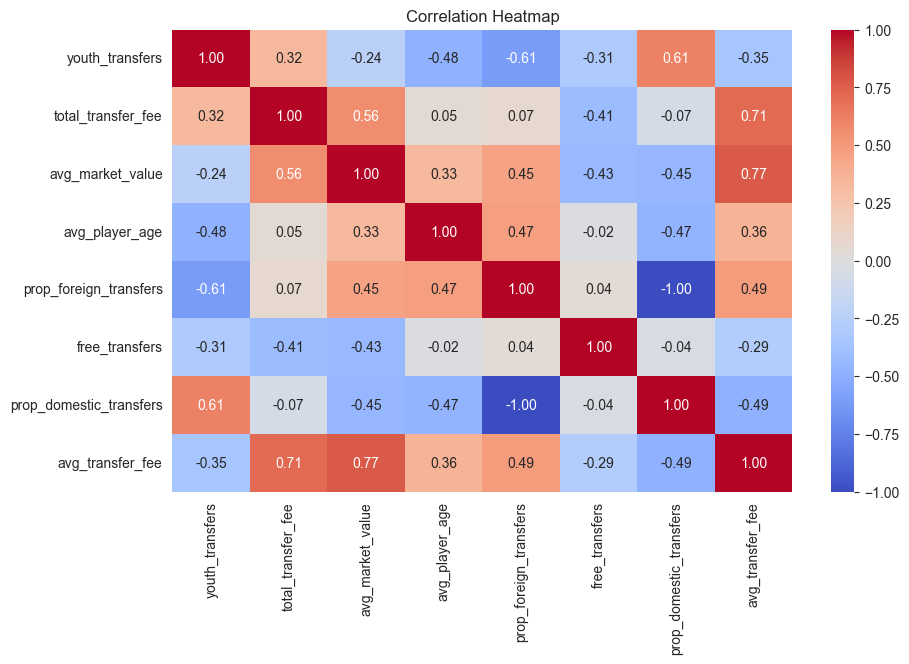

In [54]:
# Selecting Only numeric columns
numeric_cols = [
    "youth_transfers",
    "total_transfer_fee",
    "avg_market_value",
    "avg_player_age",
    "prop_foreign_transfers",
    "free_transfers",
    "prop_domestic_transfers",
    "avg_transfer_fee"
]

# Identifying the correlation between Numeric columns
corr = league_season[numeric_cols].corr()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

The Heatmap shows the correlation between the features before modelling. Overall there are negative or very weak positive correlation between most of the features. There is a strong positive correlation between the average transfer fee and the average market value (0.77). We can also see a strong correlation between the average transfer fee and the total transfer fee which is to be expected since they are just statistics from the same transfer fee. The heatmap also shows a fairly strong correlation youth transfers and the proportion of domestic transfers.

## 2. 6 Poisson Distribution for Outgoing Youth Transfers

The Poisson model tests which factors significantly influence the number of outgoing youth transfers players across Europe’s top leagues from 2009–2021. The target variable is youth_transfers, representing the number of youth players leaving each league each season. Because the target variable is a count variable, we apply a Poisson regression model. If over-dispersion which is when variance is greater than the mean, is detected, a Quassipoisson  model will be used instead.

In [55]:
# Poisson model for Outgoing youth transfers
glm_youth_out = smf.glm(
    formula=(
        "youth_transfers ~ C(league) + season + "
        "np.log1p(avg_market_value) + prop_foreign_transfers + "
        "free_transfers + avg_player_age"
    ),
    data=league_season,
    family=sm.families.Poisson()
).fit()

print(glm_youth_out.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        youth_transfers   No. Observations:                   91
Model:                            GLM   Df Residuals:                       79
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -533.74
Date:                Fri, 07 Nov 2025   Deviance:                       431.40
Time:                        13:02:01   Pearson chi2:                     428.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## 2.7 Testing for Overdispersion

If the alpha value is greater than 1.5 then we will have to use the quassipoisson to account for this overdispersion because the poisson model assumes that the mean and variance are equal to avoid misinterpretation of coefficients

In [56]:
alpha_est = glm_youth_out.pearson_chi2 / glm_youth_out.df_resid
print(f"Over-dispersion factor = {alpha_est:.2f}")

Over-dispersion factor = 5.42


In [57]:
# QuassiPoisson model for overdispersion for Outgoing youth players
glm_youth_out = smf.glm(
    formula="youth_transfers ~ C(league) + season + np.log1p(avg_market_value) + \
             prop_foreign_transfers + free_transfers + avg_player_age + np.log1p(avg_transfer_fee)",
    data=league_season,
    family=sm.families.Poisson()
).fit(cov_type="HC3")

print(glm_youth_out.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        youth_transfers   No. Observations:                   91
Model:                            GLM   Df Residuals:                       78
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -519.84
Date:                Fri, 07 Nov 2025   Deviance:                       403.61
Time:                        13:02:01   Pearson chi2:                     398.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Exponentiate coefficients before making interpretations for a poisson model

In [58]:
irr_out = np.exp(glm_youth_out.params)
print(irr_out)

Intercept                     3.553990e+10
C(league)[T.FR1]              1.285668e+00
C(league)[T.GB1]              1.311391e+00
C(league)[T.IT1]              3.273628e+00
C(league)[T.L1]               9.857322e-01
C(league)[T.NL1]              1.445437e+00
C(league)[T.PO1]              1.564669e+00
season                        9.936659e-01
np.log1p(avg_market_value)    1.276132e+00
prop_foreign_transfers        4.460962e-01
free_transfers                5.441779e-01
avg_player_age                6.743056e-01
np.log1p(avg_transfer_fee)    8.906878e-01
dtype: float64


The analysis shows that youth-transfer activity is primarily shaped by league-level structural and financial factors, not by seasons. League effects dominate. The Serie A (IT1) and the Premier League all exhibit substantially higher number of outgoing youth transfers than La Liga. The Serie A, in particular exports the number of youth players almost triple the amount of the others. Leagues with higher-valued players (market value) tend to have more outgoing youth transfers. There is weak evidence that the proportion of foreign transfers is associated with number of youth outgoing transfers, implying that leagues focus more on outgoing transfers within domestic competitions. The analysis also shows that when the average transfer fee is high, leagues tend to make less outgoing transfers

## 3. INCOMING YOUTH PLAYERS

After performing analysing on the outgoing youth transfers, twe decided to investigate the incoming youth players. Those youth youth players being signed into each league over time. This will help us reveal whether certain leagues act primarily as talent importers or exporters. Before analysis, we performed data preparation to perform the analysis focusing on just the incoming youth players.

## 3. 1 Data Preparation for Incoming Youth transfers by Leagues Over Time

In [59]:
# Filter dataset
youth_in_df = transfer_df[(transfer_df["age_group"] == "youth") & (transfer_df["dir"] == "in")].copy()

# To convert binary to 0, 1
youth_in_df.loc[:, "is_free_num"] = youth_in_df["is_free"].astype(int)

print(youth_in_df["is_free_num"].value_counts())

# Converting categorical variables to strings for pandas comparability
youth_in_df["counter_team_country"] = youth_in_df["counter_team_country"].astype(str)
youth_in_df["team_country"] = youth_in_df["team_country"].astype(str)

# Identifying whether players are transferred domestically or internationally
youth_in_df["transfer_type"] = (youth_in_df["team_country"] != youth_in_df["counter_team_country"]).astype(int)

is_free_num
0    15948
1     1480
Name: count, dtype: int64


Following data preparation, We decided to visualize the number of youth players entering each league per season, and whether this varies between Europe’s top leagues across the seasons. By aggregating the data at the league-season level and incorporating metrics such as average transfer fee, total spending, and player age.

In [60]:
# Group by league and season
league_season_in = (
    youth_in_df.groupby(["league", "season"], observed=False)
    .agg(
        # Target Variable
        youth_transfers = ("player_id", "count"),
        # Financial metrics
        avg_transfer_fee = ("transfer_fee_amnt", lambda x: round(x.mean(), 2)),
        total_transfer_fee = ("transfer_fee_amnt", lambda x: round( x.sum(), 2)),
        avg_market_value = ("market_val_amnt", lambda x: round(x.mean(), 2)),
        # Player demographic
        avg_player_age = ("player_age", lambda x: round(x.mean(), 2)),
        # Player Destination Country
        prop_foreign_transfers = ("transfer_type", "mean"),
        prop_domestic_transfers = ("transfer_type", lambda x: 1 - x.mean()),
        # Free Transfers
        free_transfers = ("is_free", lambda x: round(x.mean(), 2))
    )
    .reset_index()
)

print(league_season_in.head())

# Plot
fig6 = px.bar(
    league_season_in,
    x="season",
    y="youth_transfers",
     color="league",
    hover_data= ["youth_transfers",
                 "total_transfer_fee",
                 "avg_transfer_fee",
                 "avg_market_value",
                 "avg_player_age",
                 "prop_foreign_transfers",
                 "free_transfers",
                 "prop_domestic_transfers"],
    title="Incoming Youth Transfer Trends Over Time by League",
    template="plotly_dark"
)

fig6.show()


  league  season  youth_transfers  avg_transfer_fee  total_transfer_fee  \
0    ES1    2009              136        1130147.06         153700000.0   
1    ES1    2010              119         918739.50         109330000.0   
2    ES1    2011              138        1274927.54         175940000.0   
3    ES1    2012              119         486134.45          57850000.0   
4    ES1    2013              139        1685071.94         234225000.0   

   avg_market_value  avg_player_age  prop_foreign_transfers  \
0        1356617.65           21.16                0.227941   
1        1822478.99           21.34                0.285714   
2        3532065.22           21.36                0.362319   
3        3009873.95           21.44                0.294118   
4        6175179.86           21.05                0.402878   

   prop_domestic_transfers  free_transfers  
0                 0.772059            0.07  
1                 0.714286            0.09  
2                 0.637681         

This chart shows the total number of youth players entering each league per season (2008-2021). The Premier League (GB1) and Liga Portugal Bwin shows the higher number of transfers across the seasons, indicating the leagues strong reliance on acquiring external youth talent. However, from 2016 the number of youth imports in the Premier League continued to decrease, this may be due to the focus on developing and retaining youth players in their respective clubs. The La Liga (ES1) shows a steady upward and downward trend of the number of import transfers of youth players, indicating a moderate number of imported young players. The Serie A (IT1) shows the lowest imports of youth players, showing their focus on developing talents rather than purchasing many young players from other clubs within the leagues or abroad.

## 3. 2 Proportion of Incoming Youth Foreign Transfers Over Time

After analysing the total number of incoming youth transfers, similar to the outgoing transfers, we decided to focus specifically on the proportion of those transfers that are coming from foreign leagues. The intention behind this analysis was to understand the extent of international integration within each domestic league’s recruitment strategy and identify how much each league relies on foreign transfers.

In [61]:
fig7 = px.line(
    league_season_in,
    x="season",
    y="prop_foreign_transfers",
    color="league",
    markers=True,
    title="Proportion of Incoming Foreign Youth Transfers Over Time by League",
    labels={
        "season": "Season",
        "prop_foreign_transfers": "Proportion of Outgoing Foreign Transfers"
    },
    template="plotly_dark"
)

fig7.update_yaxes(tickformat=".0%")
fig7.show()

Almost all the leagues show a gradual increase in the proportion of foreign youth players entering their leagues from 2009 to 2021. These shows the growing globalization of youth recruitment, where clubs increasingly scount and sign young players from abroad especially in the Premier League (GB1). The Premier League shows the highest increase of about 60% in 2021. This suggests over half of the youth players joining English clubs come from outside the UK, indicating a strong international scouting network and financial capacity to attract young talents from foreign leagues. The Seria A (IT1) league shows an upward and downward trend across the seasons, showing a moderate import of foreign youth players below 40% reflecting the leagues preference for domestic development. The La Liga (ES1) remains the least dependent on foreign youth transfers across the seasons 2009 to 2021, although they had a few high proportion of incoming youth players (40%) in 2013 and 2014, it continued to decrease throughout the remaining seasons, showing that the spanish league depended more on domestic youth players and retaining those youth players in their respective clubs

## 3. 3 Modelling with Quassipoisson for Overdispersion

Following the Poisson regression model for incoming youth transfers, Since we know the data we have the mean is different from the variance, from our previous analysis, we performed a quassipoisson directly to avoid biased coefficients from the overdispersion since standard errors become very small, some p-values may seem significant leading to false positives. The model includes predictors such as league, season, average market value, average transfer fee, proportion of foreign transfers, free transfers, and average player age. These variables collectively to confirm our analysis statistically and to understand how both financial and structural factors that influence the number of youth players entering each league. By using robust standard errors we set cov_type="HC3", for the model to provide us more reliable coefficient estimates.

In [62]:
# QuassiPoisson model for overdispersion
glm_youth_in = smf.glm(
    formula="youth_transfers ~ C(league) + season + np.log1p(avg_market_value) + \
             prop_foreign_transfers + free_transfers + avg_player_age + np.log1p(avg_transfer_fee)",
    data=league_season_in,
    family=sm.families.Poisson()
).fit(cov_type="HC3")

print(glm_youth_in.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        youth_transfers   No. Observations:                   91
Model:                            GLM   Df Residuals:                       78
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -493.39
Date:                Fri, 07 Nov 2025   Deviance:                       343.70
Time:                        13:02:02   Pearson chi2:                     336.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9989
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Exponentiate to interpret coefficients

In [63]:
irr_in = np.exp(glm_youth_in.params)
print(irr_in)

Intercept                     25.059537
C(league)[T.FR1]               1.061123
C(league)[T.GB1]               1.449774
C(league)[T.IT1]               1.061909
C(league)[T.L1]                0.928559
C(league)[T.NL1]               1.042814
C(league)[T.PO1]               1.577571
season                         1.003186
np.log1p(avg_market_value)     1.063447
prop_foreign_transfers         0.448790
free_transfers                 1.171541
avg_player_age                 0.777158
np.log1p(avg_transfer_fee)     1.000965
dtype: float64


The analysis shows that the Premier League is the top destinations for youth players, each showing significantly higher import rates than La Liga, However for the italian leagues there is no significant evidence. Similar with the export model, younger youth players are moved more frequently in both incoming and outgoing, suggesting that leagues attract players earlier in their careers. There is no significant evidence for prop_foreign_transfers influencing the number of youth incoming transfers, indicating most transfers might be domestic. Market value and season are not statistically significant. Average transfer fee is not driven by the number of youth transfers, no statistical evidence.

## 3. 4 Identifying the difference between transfer exports and imports per league

After independently analysing the trends of outgoing and incoming youth transfers, we decided to combines both perspectives to by calculating each league’s net balance of youth player transfer movement. The main goal was to determine whether European leagues act primarily as exporters (developing and selling young players abroad) or importers (buying and attracting youth talent). To achieve this, the data was grouped by league and season then we calculated the total number of youth exports (players leaving) and imports (players entering). We took the difference between exports and imports then it normalised to account for varied league sizes to produce a net export ratio(%).

In [64]:
# Number of exported youth players
export_counts = (
   transfer_df[(transfer_df["dir"] == "left") & (transfer_df["age_group"] == "youth")]
    .groupby(["league", "season"],  observed=False)
    .agg(
        youth_export=("player_id", "count"),
        avg_transfer_fee_out=("transfer_fee_amnt", lambda x: round(x.mean(), 2)),
        avg_market_value_out=("market_val_amnt", lambda x: round(x.mean(), 2)),
    )
    .reset_index()
)

# Number of imported youth players
import_counts = (
    transfer_df[(transfer_df["dir"] == "in") & (transfer_df["age_group"] == "youth")]
    .groupby(["league", "season"],  observed=False)
    .agg(
        youth_import=("player_id", "count"),
        avg_transfer_fee_in=("transfer_fee_amnt", lambda x: round(x.mean(), 2)),
        avg_market_value_in=("market_val_amnt", lambda x: round(x.mean(), 2))
    )
    .reset_index()
)

# Merge
balance = export_counts.merge(import_counts, on=["league", "season"], how="outer")

# Net metrics
balance["net_export"] = (
        (balance["youth_export"] - balance["youth_import"]) / (balance["youth_export"] + balance["youth_import"])
) * 100
balance["net_transfer_fee_diff"] = balance["avg_transfer_fee_out"] - balance["avg_transfer_fee_in"]
balance["net_market_value_diff"] = balance["avg_market_value_out"] - balance["avg_market_value_in"]

# Plot
fig8 = px.line(
    balance,
    x="season",
    y="net_export",
    color="league",
    markers= True,
    title="Net Youth Transfers by League (Exports − Imports)",
    labels={"league": "League", "net_export_balance": "Net Export Balance"},
    hover_data=[
        "youth_export",
        "youth_import",
        "avg_transfer_fee_out",
        "avg_transfer_fee_in",
        "net_transfer_fee_diff",
        "net_market_value_diff",
    ],
    template="plotly_dark",
)
fig8

Serie A (IT1) shows a higher net export rate compared to the other leagues, maintaining a positive net export rate from about 30% to a highest rate of about 50% across the 2009 to 2021 season. This means that the Italian clubs are major youth exporters, they develop young talent domestically and retain most of them in the Italian league as shown above. All the other leagues such as the La Liga (ES1) and Premier League (GB1) on the other hand mostly have a net export rate between 0 and -20% indicating that they are slight net importers of youth players rather than exporters. So although Italian (Seria A) teams have the most number of transfers, most of these transfers are outgoing transfers and they are domestic transfers.

## 4. PRIME PLAYERS

## OUTGOING PRIME PLAYERS

## 4. 1 Data Preparation for Analysis

After analysing youth transfer patterns, the next logical step for us was to focus on prime transfer patterns. This is when a football player is considered experienced and ready for the competition. This would help us compare between developmental transfers (youth) and performance-driven transfers (prime), revealing how market behaviour and league strategies differ depending on player maturity. A similar data preparation was performed before further analysis and visualisation, such as to identify which leagues most frequently sell or acquire prime players, whether transfers are predominantly domestic or international, and how transfer fees differ relative to youth transactions. The analysis performed on youth transfers is also performed on the Prime transfers, hence why there wont be an introductory part for each analysis unless it differs from the previous ones

In [65]:
# Filter dataset
prime_df = transfer_df[(transfer_df["age_group"] == "prime")].copy()

# To convert binary columns to 0 and 1
prime_df["is_free_num"] = prime_df["is_free"].astype(int)

# Convert categorical columns to string for comparison
prime_df["counter_team_country"] = prime_df["counter_team_country"].astype(str)
prime_df["team_country"] = prime_df["team_country"].astype(str)

# Identify whether players are transferred domestically (0) or internationally (1)
prime_df["transfer_type"] = (prime_df["team_country"] != prime_df["counter_team_country"]).astype(int)

# Group by league and season function to calculate statistics
def agg_league_season(df):
    return (
        df.groupby(["league", "season"], observed=False)
        .agg(
            # Number of Prime players
            prime_transfers=("player_id", "count"),
            # Financial metrics
            avg_transfer_fee=("transfer_fee_amnt", "mean"),
            total_transfer_fee=("transfer_fee_amnt", "sum"),
            avg_market_value=("market_val_amnt", "mean"),
            # Player demographics
            avg_player_age=("player_age", "mean"),
            # Transfer type
            prop_foreign_transfers=("transfer_type", "mean"),
            prop_domestic_transfers=("transfer_type", lambda x: 1 - x.mean()),
            # Free transfers
            free_transfer_rate=("is_free_num", "mean"),
        )
        .reset_index()
        .round(3)
    )

## 4. 2 Exploring Number of Outgoing Prime Transfers by the Leagues Over Time

In [66]:
# Filtering Outgoing transfers
prime_df_left = prime_df[prime_df["dir"] == "left"].copy()

# Using the function to get the statistics for the Outgoing prime player
prime_league_season_left = agg_league_season(prime_df_left)

# Plot outgoing prime transfers
fig9 = px.bar(
    prime_league_season_left,
    x="season",
    y="prime_transfers",
    color="league",
    hover_data=[
        "prime_transfers",
        "total_transfer_fee",
        "avg_transfer_fee",
        "avg_market_value",
        "avg_player_age",
        "prop_foreign_transfers",
        "prop_domestic_transfers",
        "free_transfer_rate",
    ],
    title="Outgoing Prime Transfer Trends Over Time by League",
    template="plotly_dark"
)
fig9.show()

The total number of outgoing prime-player transfers increased from 2009 till 2014 where it remained stable till 2019, then it decreased till 2021, likely due to the COVID-19 pandemic’s impact on club finances. Serie A (IT1) dominates the chart, showing the largest share of outgoing prime-player transfers throughout the period. The La Liga (ES1) and the Premier League (GB1) have a low number of outgoing prime transfers which have been fairly consistent across the seasons. These two leagues show moderate and steady outflows, indicating their financial capacity to retain prime players while still participating actively in the global transfer market.

## 4. 3 Proportion of Outgoing Foreign Youth Transfers by Leagues Over Time

In [67]:
# Plot proportion of Out foreign prime transfers
fig3 = px.line(
    prime_league_season_left,
    x="season",
    y="prop_foreign_transfers",
    color="league",
    markers=True,
    title="Proportion of Outgoing Foreign Prime Transfers Over Time by League",
    labels={"prop_foreign_transfers": "Proportion of Outgoing Foreign Transfers"},
    template="plotly_dark"
)
fig3.update_yaxes(tickformat=".0%")
fig3.show()

This chart shows the La liga (ES1) remains steady between 40 % and 50 %, implying that most prime-player moves are domestic.
The English Premier League shows a gradual increase in foreign outgoing prime players from around 40% in 2009 to over 60% by 2021. This trend suggests growing international activity of English-based prime players, despite the league’s strong domestic attraction. The Italian Serie A league on the other hand, demonstrates the lowest proportion of foreign prime transfers betwem 25 to 40% throughout the seaons, confirming that most transfers occur within Italy itself. This could be the reason behind Italy not having the highest transfer fees although the Serie A league has the highest number of transfers across the seasons.
Around 2015–2016, several leagues especially the Netherlands and France reached their highest foreign-transfer proportions, possibly linked to post-Financial Fair Play market adjustments.

## 4.4 Quassipoison for Outgoing Prime Players

In [68]:
# QuassiPoisson model for overdispersion
glm_prime_out = smf.glm(
    formula="prime_transfers ~ C(league) + season + np.log1p(avg_market_value) + \
             prop_foreign_transfers  + avg_player_age + np.log1p(avg_transfer_fee)",
    data=prime_league_season_left,
    family=sm.families.Poisson()
).fit(cov_type="HC3")

print(glm_prime_out.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        prime_transfers   No. Observations:                   91
Model:                            GLM   Df Residuals:                       79
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -417.30
Date:                Fri, 07 Nov 2025   Deviance:                       215.36
Time:                        13:02:03   Pearson chi2:                     215.
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [69]:
irr_prime_out = np.exp(glm_prime_out.params)
print(irr_prime_out)

Intercept                     2.575774e+38
C(league)[T.FR1]              7.881004e-01
C(league)[T.GB1]              9.010175e-01
C(league)[T.IT1]              1.576170e+00
C(league)[T.L1]               6.261921e-01
C(league)[T.NL1]              7.163120e-01
C(league)[T.PO1]              1.402567e+00
season                        9.599072e-01
np.log1p(avg_market_value)    1.150753e+00
prop_foreign_transfers        8.122024e-01
avg_player_age                9.312107e-01
np.log1p(avg_transfer_fee)    9.375976e-01
dtype: float64


The model shows that the Serie A (IT1) shows the highest number of outgoing prime player transfers, sending out around 58 % more prime-age players than La Liga (ES1). The Premier League (GB1) displays a 10 % lower export rate than La Liga. The negative time trend confirms that from 2009–2021, the European transfer market for prime players slightly declined by 4% each year. Market value increases the number of prime transfers, for every unit increase in average market value leads to 15% more increase in outgoing number of prime transfers, indicating leagues with higher value players are more likely to transfer players.

## 5. INCOMING PRIME PLAYERS

## 5. 1 Exploring Number of Incoming Prime Transfers by the Leagues Over Time

In [70]:
# Incoming transfers (players joining the league)
prime_df_in = prime_df[prime_df["dir"] == "in"].copy()
prime_league_season_in = agg_league_season(prime_df_in)

# Plot incoming prime transfers
fig2 = px.bar(
    prime_league_season_in,
    x="season",
    y="prime_transfers",
    color="league",
    hover_data=[
        "prime_transfers",
        "total_transfer_fee",
        "avg_transfer_fee",
        "avg_market_value",
        "avg_player_age",
        "prop_foreign_transfers",
        "prop_domestic_transfers",
        "free_transfer_rate",
    ],
    title="Incoming Prime Transfer Trends Over Time by League",
    template="plotly_dark"
)
fig2.show()

Similar to the outgoing prime transfers, there is a visible drop after 2018 till 2021, likely linked to the COVID-19 pandemic, which reduced transfer budgets and player movement. The relatively consistent bar heights indicates that overall European leagues have maintained a steady demand for prime-age players, possibly due to their experience and age since they are still considered young.  The Italy Serie A (IT1) shows a declining share of incoming transfers over time, particularly after 2015, suggesting that Italian clubs are importing fewer prime players and possibly focusing more on domestic or younger talent.
The Premier League (GB1) maintains a consistent level of incoming prime players, reflecting its selective but consistent import strategy.  The La liga (ES1) shows an increase in incoming prime aged players from 2009 till 2012 where it stayed moderately consistent till 2019 then decreased till 2021.

## 5. 2 Proportion of Incoming Foreign Prime Transfers by Leagues Over Time

In [71]:
# Plot proportion of Incoming foreign prime transfers
fig3 = px.line(
    prime_league_season_in,
    x="season",
    y="prop_foreign_transfers",
    color="league",
    markers=True,
    title="Proportion of Incoming Foreign Prime Transfers Over Time by League",
    labels={"prop_foreign_transfers": "Proportion of Incoming Foreign Transfers"},
    template="plotly_dark"
)
fig3.update_yaxes(tickformat=".0%")
fig3.show()

Across all leagues, the proportion of foreign incoming prime players generally ranges from 30% to 70%, suggesting a mix of domestic and international recruitment strategies. The Premier League (GB1) shows an upward trajectory, starting at around 35% in 2009 and rising to nearly 65 % by 2021. This sharp increase over time shows the league’s growing dependence on foreign prime players. The Italian Seria A (IT1) shows the lowest share of incoming foreign transfers ranging approximately between 30 to 43% across most seasons with a sharp decline in 2011 below 30%, indicating that Italian clubs prefer domestic incoming prime players. La Liga (ES1) shows moderate share of foreign prime player transfers ranging between around 40 to 55%, with the highest recorded in 2016. Between 2010 and 2015, most leagues maintained stable proportions, with slight increases reflecting transfer market globalization. The sharp increase in 2021 in multiple leagues may indicate a post-pandemic rebound, as clubs resumed international recruitment.

## 5.3 Quassipoisson for Number of Incoming Prime players

In [72]:
# QuassiPoisson model for overdispersion
glm_prime_in = smf.glm(
    formula="prime_transfers ~ C(league) + season + np.log1p(avg_market_value) + \
             prop_foreign_transfers  + avg_player_age + np.log1p(avg_transfer_fee)",
    data=prime_league_season_in,
    family=sm.families.Poisson()
).fit(cov_type="HC3")

print(glm_prime_in.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        prime_transfers   No. Observations:                   91
Model:                            GLM   Df Residuals:                       79
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -419.71
Date:                Fri, 07 Nov 2025   Deviance:                       237.05
Time:                        13:02:04   Pearson chi2:                     232.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9999
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [73]:
irr_prime_in = np.exp(glm_prime_in.params)
print(irr_prime_in)

Intercept                     7.665312e+27
C(league)[T.FR1]              7.300282e-01
C(league)[T.GB1]              8.771249e-01
C(league)[T.IT1]              8.123558e-01
C(league)[T.L1]               5.776418e-01
C(league)[T.NL1]              6.184599e-01
C(league)[T.PO1]              1.358058e+00
season                        9.700007e-01
np.log1p(avg_market_value)    1.122418e+00
prop_foreign_transfers        6.622954e-01
avg_player_age                1.039856e+00
np.log1p(avg_transfer_fee)    9.827526e-01
dtype: float64


The model shows Serie A (IT1) transfer 19 % less prime-age players than La Liga (ES1). This shows Italy’s focus on exporting more than import mid-career players. The Premier League (GB1) shows no significance difference in incoming prime transfers compared to La Liga. Leagues with higher average market value influence 12 % more incoming prime aged transfers, indicating that richer markets attract mid-career professionals. The season shows no significant effect on the number of transfers made for incoming prime-aged players. Other predictors such as average transfer fees, age and foreign share are not significant.


## 5. 4 Identifying the difference between transfer exports and imports per league for prime players

After independently analysing the trends of outgoing and incoming prime transfers, we decided to evaluate league’s net balance and net differences in average transfers of prime player movement. The main goal was to determine whether European leagues act primarily as exporters  or importers . et. To achieve this, the data were grouped by league and season before making these calulations to identify the net balance in number of exports and imports and the net differences in average transfers in exports and imports. These have been visualised below.

In [74]:
# Merge outgoing and incoming data by league and season
prime_net = (
    prime_league_season_left
    .rename(columns={
        "prime_transfers": "prime_out",
        "avg_transfer_fee": "avg_fee_out",
        "avg_market_value": "avg_mv_out"
    })
    .merge(
        prime_league_season_in.rename(columns={
            "prime_transfers": "prime_in",
            "avg_transfer_fee": "avg_fee_in",
            "avg_market_value": "avg_mv_in"
        }),
        on=["league", "season"],
        how="outer"
    )
)

# Compute net export and transfer fee difference
prime_net["net_prime_flow"] = (
    prime_net["prime_out"].fillna(0) - prime_net["prime_in"].fillna(0)
)
prime_net["net_fee_gap"] = (
    prime_net["avg_fee_out"].fillna(0) - prime_net["avg_fee_in"].fillna(0)
)

# Plot Net Prime Transfers by League
fig4 = px.bar(
    prime_net,
    x="season",
    y="net_prime_flow",
    color="league",
    hover_data=["prime_out", "prime_in", "avg_fee_out", "avg_fee_in", "net_fee_gap"],
    title="Net Prime Transfers by League (Exports − Imports)",
    labels={"net_prime_flow": "Net Prime Transfers"},
    template="plotly_dark"
)
fig4.show()

The bar chart shows, across all seasons, most leagues show positive net values, meaning they generally export more prime-age players than they import. The net transfer balance fluctuates over time but remains consistently dominated by a few leagues.
Serie A (IT1) dominates the chart throughout, showing the largest and most consistent export surplus of prime-age players each year. This indicates that Italian clubs regularly transfer more established players than they bring in. This aligns with regression findings where prop_foreign_transfers had a negative coefficient, reflecting Serie A’s strong export activity domestically. La Liga’s (ES1) net balance seems fairly neutral, indicating La Liga has a balance approach of both acquiring and exporting prime players. The Premier League (GB1) is also similar to La Liga where during some seasons it exports more and others it is fairly stable or even more of an importer like in 2015. Once again, the decrease after 2019 across most leagues shows the pandemic’s economic impact, as clubs curtailed spending and international movement decreased.

In [75]:
# Plot Average Net Transfer Fee Gap
fig5 = px.line(
    prime_net,
    x="season",
    y="net_fee_gap",
    color="league",
    markers=True,
    title="Difference in Average Transfer Fees (Prime Players)",
    labels={"net_fee_gap": "Average Fee Difference (Out − In)"},
    template="plotly_dark"
)
fig5.add_hline(y=0, line_dash="dash", line_color="gray")
fig5.show()

The chart shows the average transfer fee differences that fluctuate around the zero baseline, highlighting seasonal shifts between net-selling and net-buying seasons across the seasons. The Premier League (GB1) stands out with consistently negative average fee transfer differences, indicating more spending on incoming prime players than it earns from outgoing players. The Serie A (IT1) also shows increasingly negative difference in average transfer fees over time, also indicating that the Italian league spends more on incoming players while earning less from outgoing transfers. The La Liga (ES1)  pattern hovers close to zero, alternating slightly above and below the line across the seasons, suggesting a balanced market, where more money is obtained from exports compared to imports and vice versa.

## 6.   Scraping across the 2009-2021 seasons to Identify whether league youth transfer balance influence its clubs success

The motivation behind this scraping was to expand our analysis beyond financial and demographic patterns and explore whether the youth and prime transfer patterns have an influence in a Leagues Success. To achieve this, league performance data were scraped from Wikipedia for the seasons from 2009 to 2021, focusing on the Premier League (GB1) and Serie A (IT1).

In [76]:
headers = {"User-Agent": "Mozilla/5.0"}

# Dictionary of League code names and the actual name of the leagues
leagues = {
    "GB1": "Premier_League",
    "IT1": "Serie_A",
}

# List of Seasons to scrape
seasons = [
    ("2009", "10"), ("2010", "11"), ("2011", "12"), ("2012", "13"), ("2013", "14"),
    ("2014", "15"), ("2015", "16"), ("2016", "17"), ("2018", "19"), ("2019", "20"), ("2020", "21")
]

# Empty list to store each league's DataFrame
all_dfs = []

for code, wiki_name in leagues.items():
    for start, end in seasons:
        url = f"https://en.wikipedia.org/wiki/{start}%E2%80%93{end}_{wiki_name}"
        r = requests.get(url, headers=headers)
        soup = BeautifulSoup(r.text, "html.parser")

        league_header = soup.find(id="League_table")
        if league_header:
            table = league_header.find_next("table", class_="wikitable")
        else:
            table = soup.find("table", class_="wikitable")

        if table is None:
            print(f"No table found for {wiki_name} {start}-{end}")
            continue

        df = pd.read_html(StringIO(str(table)))[0]
        df["league"] = code
        df["season"] = f"{start}-{end}"
        all_dfs.append(df)

# Combine all dataframes
all_data = pd.concat(all_dfs, ignore_index=True)
print(all_data.head())

   Pos               Team  Pld   W   D   L   GF  GA   GD Pts  \
0    1        Chelsea (C)   38  27   5   6  103  32  +71  86   
1    2  Manchester United   38  27   4   7   86  28  +58  85   
2    3            Arsenal   38  23   6   9   83  41  +42  75   
3    4  Tottenham Hotspur   38  21   7  10   67  41  +26  70   
4    5    Manchester City   38  18  13   7   73  45  +28  67   

                         Qualification or relegation league   season Teamvte  
0  Qualification for the Champions League group s...    GB1  2009-10     NaN  
1  Qualification for the Champions League group s...    GB1  2009-10     NaN  
2  Qualification for the Champions League group s...    GB1  2009-10     NaN  
3  Qualification for the Champions League play-of...    GB1  2009-10     NaN  
4  Qualification for the Europa League play-off r...    GB1  2009-10     NaN  


In [77]:
all_data["season"].unique()
all_data["Team"].unique()

array(['Chelsea (C)', 'Manchester United', 'Arsenal', 'Tottenham Hotspur',
       'Manchester City', 'Aston Villa', 'Liverpool', 'Everton',
       'Birmingham City', 'Blackburn Rovers', 'Stoke City', 'Fulham',
       'Sunderland', 'Bolton Wanderers', 'Wolverhampton Wanderers',
       'Wigan Athletic', 'West Ham United', 'Burnley (R)',
       'Hull City (R)', 'Portsmouth (R)', 'Manchester United (C)',
       'Chelsea', 'West Bromwich Albion', 'Newcastle United',
       'Birmingham City (R)', 'Blackpool (R)', 'West Ham United (R)',
       'Manchester City (C)', 'Swansea City', 'Norwich City',
       'Queens Park Rangers', 'Bolton Wanderers (R)',
       'Blackburn Rovers (R)', 'Wolverhampton Wanderers (R)',
       'Southampton', 'Wigan Athletic (R)', 'Reading (R)',
       'Queens Park Rangers (R)', 'Crystal Palace', 'Hull City',
       'Norwich City (R)', 'Fulham (R)', 'Cardiff City (R)',
       'Leicester City', 'Leicester City (C)', 'Watford', 'Bournemouth',
       'Newcastle United (R)

## 6. 1 Preparing Data for Analysis

In [78]:
# Select numeric columns
numeric_cols = ["Pts", "W", "D", "L", "GF", "GA", "GD"]
for col in numeric_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors="coerce")

# Aggregating data by League & Season
league_perf = (
    all_data.groupby(["league", "season"], observed=False)
    .agg(
        avg_points=("Pts", "mean"),
        std_points=("Pts", "std"),
        max_points=("Pts", "max"),
        avg_wins=("W", "mean"),
        avg_losses=("L", "mean"),
        avg_draws=("D", "mean"),
        avg_goals_for=("GF", "mean"),
        avg_goals_against=("GA", "mean"),
        avg_goal_diff=("GD", "mean")
    )
    .reset_index()
)

# Extract only the first years of each data
league_perf["season"] = (
    league_perf["season"]
    .astype(str)
    .str.extract(r"(\d{4})")[0]
)

### 6. 2 Merging Scrape data with Original Data

Following Scraping and Data preparation we merged the new data to our original transfer data for further analysis to identify the impact of the transfer patterns on the league performance

In [79]:
league_perf["season"] = league_perf["season"].astype(str).str.slice(0, 4)
transfer_df["season"] = transfer_df["season"].astype(str)

merged_df = (
    transfer_df.merge(league_perf, on=["league", "season"], how="inner")
)

In [80]:
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23761 entries, 0 to 23760
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   league                 23761 non-null  object  
 1   season                 23761 non-null  object  
 2   window                 23761 non-null  category
 3   team_id                23761 non-null  int64   
 4   team_name              23761 non-null  category
 5   team_country           23761 non-null  category
 6   dir                    23761 non-null  category
 7   player_id              23761 non-null  int64   
 8   player_name            23761 non-null  object  
 9   player_age             23761 non-null  Int64   
 10  player_nation          23761 non-null  category
 11  player_pos             23761 non-null  category
 12  counter_team_id        23552 non-null  Int64   
 13  counter_team_name      23761 non-null  category
 14  counter_team_country   23761 non-null 

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,age_group,avg_points,std_points,max_points,avg_wins,avg_losses,avg_draws,avg_goals_for,avg_goals_against,avg_goal_diff
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23,...,youth,53.473684,17.699242,86.0,14.2,14.2,9.6,52.65,52.65,34.375
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21,...,youth,53.473684,17.699242,86.0,14.2,14.2,9.6,52.65,52.65,34.375
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20,...,youth,53.473684,17.699242,86.0,14.2,14.2,9.6,52.65,52.65,34.375
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29,...,prime,53.473684,17.699242,86.0,14.2,14.2,9.6,52.65,52.65,34.375
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18,...,youth,53.473684,17.699242,86.0,14.2,14.2,9.6,52.65,52.65,34.375


### 6. 3 Linear Modelling

The initial modelling was to identify the overall league performance with the transfer patterns, however when grouped on league-season level, we will not have enough data so the statistical modelling will not be significant. So instead, we performed a linear model to explain the variation in transfer fees using multiple predictors such as the player, characteristics, transfer type, league and interactions to identify how the effect of age group on transfer fees depends on the transfer direction whether incoming or outgoing due to limited sample size we cannot perform linear regression to identify the interaction between league and season for transfer fees when grouped by league and season. Transfer fees are modeled on a logarithmic scale, meaning that the coefficients reflect percentage changes rather than absolute changes, allowing for a meaningful comparison of proportional effects between leagues and player groups.

In [81]:
# Log Transformation on skewed features
merged_df["log_transfer_fee"] = np.log1p(merged_df["transfer_fee_amnt"])
merged_df["log_market_val"] = np.log1p(merged_df["market_val_amnt"])

# If it is a foreign transfer 1 else 0
merged_df["foreign_transfer"] = np.where(
    merged_df["counter_team_country"].astype(str) != merged_df["team_country"].astype(str),
    1, 0
)

# OLS model
linear_model = smf.ols(
    "log_transfer_fee ~ log_market_val * C(league) + C(age_group) * C(league) + "
    "C(age_group) * C(dir) + C(age_group) * is_free + player_age + "
    "is_loan + foreign_transfer + C(season)",
    data=merged_df
).fit()

print(linear_model.summary())



                            OLS Regression Results                            
Dep. Variable:       log_transfer_fee   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     753.4
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:02:34   Log-Likelihood:                -70526.
No. Observations:               23761   AIC:                         1.411e+05
Df Residuals:                   23734   BIC:                         1.413e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [82]:
# Acquire the raw coefficients
coefs = linear_model.params

# Exponentiate them for Interpretation
exp_coefs = np.exp(coefs)

# Combine both in a table for readability
coef_table = pd.DataFrame({
    "Coefficient": coefs,
    "Exp(Coefficient)": exp_coefs,
    "Interpretation (%)": (exp_coefs - 1) * 100
})

# Round for readability
coef_table = coef_table.round(3)

print(coef_table)

                                          Coefficient  Exp(Coefficient)  \
Intercept                                       4.900           134.320   
C(league)[T.IT1]                               -0.906             0.404   
C(age_group)[T.veteran]                        -3.223             0.040   
C(age_group)[T.youth]                          -2.323             0.098   
C(dir)[T.left]                                 -1.970             0.139   
is_free[T.True]                               -10.432             0.000   
is_loan[T.True]                                -7.800             0.000   
C(season)[T.2010]                              -0.073             0.929   
C(season)[T.2011]                              -0.005             0.995   
C(season)[T.2012]                              -0.367             0.693   
C(season)[T.2013]                              -0.813             0.444   
C(season)[T.2014]                              -0.793             0.452   
C(season)[T.2015]        

The multiple linear regression model explains approximately 45% of the variation in transfer fees (R² = 0.45, p < 0.000 meaning the p-value is very small and close to 0), indicating that league differences, player characteristics, and transfer all collectively have a strong and statistically significant influence on player valuation across European football.

Across all leagues, player market value seems to be the strongest predictor of transfer fees. A 1% increase in a player’s market valuation is associated with roughly a 15.8% increase in transfer fee, confirming that market value is an accurate reflection of player worth in the transfer market. The interaction between market value and Serie A (β = 0.112, p < 0.001) suggests that the Serie A transfer fees are even more sensitive to changes in player market value than the Premier League. Although the Italian market operates at a lower baseline, it reacts more strongly to high-value players, implying that top-tier talents in Serie A lead to higher transfer fees compared to players in the Premier League.



The coefficient for Serie A (β = −0.906, exp(β) = 0.404) indicates that, transfer fees in Serie A are approximately 60% lower than in the Premier League (the reference league). This means that a player with similar characteristics such as age and market value would cost less than in Serie A compared to the Premier League.

Player age and experience also influence transfer fees: veterans influence about 96% lower transfer fees, while youth players are valued roughly 90% lower, compared to prime-aged players. However, interaction effects show more insights: veterans in Serie A have approximately 92% more market valuations compared to veterans in the Premier League, reflecting Italian clubs tendency to value experience. On the other hand, youth players in Serie A are valued about 25% less than those in the Premier League, suggesting that English clubs are invest more in young potential, whereas Italian clubs remain more cautious and invest more in veterans.

The direction of transfer also plays an important role in determining player transfer fee. For Outgoing transfers (left) (-1.97, p < 0.001) indicates that, holding all other factors constant, players leaving a club are associated with lower transfer fees than incoming players. When exponentiated (exp(-1.97) = 0.139), this suggests that outgoing transfers are on average, approximately 86% cheaper than incoming ones. However, the interaction term for outgoing youth players (1.715, exp = 5.56) reveals that youth players leaving their clubs have significantly higher fees, suggesting that clubs tend to profit more when selling promising young talent. On the other hand, for prime-age players (the baseline age group, exp = 0.139) shows that when these players leave their club, the fees are about 86% lower than for similar incoming players. For veteran players, the interaction term (coef = -0.169 (exp = 0.845) suggests a small, statistically insignificant difference (p = 0.416). This means that veteran transfers show no meaningful price difference between incoming and outgoing moves, this makes sense since older players normally sign for free or for a low cost.

Foreign transfers are on average 66% more expensive than domestic ones, likely due to international bidding competition. The player age also influences transfer fee as we could see in the player age groups, for each additional year of age is associated with a 25% higher transfer fee.

Finally, the seasonal effect shows that transfer fees were significantly lower between 2012 and 2020, with the highest decline in 2020 (−71%), which aligns with the financial impact of the COVID-19 pandemic on global football. Earlier years, such as 2010–2011, showed no significant differences, suggesting stability.


## 6. 4 Relationship Between Average Transfer fee and League Performance for Youth and Prime players

The purpose of this analysis was to explore whether a relationship exists between transfer market expenditure and league performance, and to determine whether this relationship differs between youth and prime players. By comparing average transfer fees with average league points, the analysis aimed to identify whether leagues that spend more on acquiring players achieve higher overall performance or if spending has diminishing or inconsistent returns. The scatter plots with ordinary least squares (OLS) trendlines were used to visualize the relationship between average transfer fees (x-axis) and average league points (y-axis) for each league. This allows more of an initial descriptive interpretation rather than a causal inference, acknowledging that other unobserved variables may also affect performance outcomes. Another limitation is due to the small number of samples, therefore, this will have to be further tested deeper on a club-season level.

In [83]:
# Subset for Youth Players
merged_df_youth = merged_df[merged_df["age_group"] == "youth"]

# Aggregate to league season level
youth_league_perf_summary = (
    merged_df_youth.groupby(["league", "season"], observed=False)
    .agg(
        avg_points=("avg_points", "mean"),
        avg_transfer_fee=("transfer_fee_amnt", "mean"),
        avg_market_val=("market_val_amnt", "mean")
    )
    .reset_index()
)

# Plot
px.scatter(
    youth_league_perf_summary,
    x="avg_transfer_fee",
    y="avg_points",
    color="league",
    trendline="ols",
    title="Relationship between Average Transfer Fee and League Performance for Youth Players"
)

In the Premier League, represented by the blue line, the trend is slightly positive, suggesting that higher average transfer spending is weakly associated with improved league performance,suggesting that clubs investing more in youth players achieve slightly better performance results. In comparison to the Serie A with trendline (orange) slopes downward, indicating a negative association between transfer spending and performance. Italian clubs that spend more on average appear to perform slightly worse, on average. This suggests that increased spending doesn’t necessarily lead to better results in Italy.

In [84]:
# Subset for Prime Players
merged_df_youth = merged_df[merged_df["age_group"] == "prime"]

# Aggregate to league season level
prime_league_perf_summary = (
    merged_df_youth.groupby(["league", "season"], observed=False)
    .agg(
        avg_points=("avg_points", "mean"),
        avg_transfer_fee=("transfer_fee_amnt", "mean"),
        avg_market_val=("market_val_amnt", "mean")
    )
    .reset_index()
)

# Plot
px.scatter(
    prime_league_perf_summary,
    x="avg_transfer_fee",
    y="avg_points",
    color="league",
    trendline="ols",
    title="Relationship between Average Transfer Fee and League Performance for Prime Players"
)

In the Premier League, the blue trendline has a slightly positive slope, indicating a weak positive association which means as clubs’ average spending on prime-age players increases, their average league points also tend to rise slightly. In contrast, the Serie A trendline (orange) slopes downward, suggesting a negative relationship between transfer spending and league points, suggesting that higher average transfer fees for prime-age players are associated with slightly lower team performance in the Serie A.

#### 3. Research Question  How do La Liga (Spain) and the Premier League (UK) differ in terms of transfer spending, and how does this spending impact the final league standings?

#### Resample to LaLiga and Premier League

In this step, the dataset is being prepared for analysis by filtering and separating data based on the league type. The code creates two new dataframes: transfer_gb1, which contains only transfers from the Premier League ('GB1'), and transfer_es1, which includes transfers from La Liga ('ES1'). This helps organize the dataset so that further analysis, comparison, or modeling can be done specifically for each league.

In [85]:
transfer_gb1 = transfer_df_r[transfer_df['league'] == 'GB1']
transfer_es1 = transfer_df_r[transfer_df['league'] == 'ES1']

## Scraping Data

To gather additional information to enrich our transfer data, we decided to perform some web scraping. We defined three seasons and two leagues (LaLiga and Premier League) for which we scraped a static final standings table to obtain the season outcomes for 2013 to 2015.

Since each season starts in autumn, for example the 2013 to 2014 season begins in 2013, the most relevant transfer windows for us are the summer and winter windows of 2013.

At first, we experimented with simple scraping from the website Sports-Reference.com to test whether it worked. After that, we asked ChatGPT to help us generate a function that could scrape data for three seasons of a specific league at once.

Finally, we also reviewed the website’s robots.txt file to ensure that we considered the legal aspects of web scraping.

#### Legal Aspect from the website

Scraping Traffic on Sports-Reference.com Sites

Sports Reference is primarily dependent on ad revenue, so we must ensure that actual people using web browsers have the best possible experience when using this site. Unfortunately, non-human traffic, ie bots, crawlers, scrapers, can overwhelm our servers with the number of requests they send us in a short amount of time. Therefore we are implementing rate limiting on the site. We will attempt to keep this page up to date with our current settings.

Currently we will block users sending requests to:

FBref and Stathead sites more often than ten requests in a minute.
our other sites more often than twenty requests in a minute.
This is regardless of bot type and construction and pages accessed.
If you violate this rule your session will be in jail for up to a day.

#### Limitations

While we were running the scraping code on Julian’s Windows laptop, we realized that Samuel and Nick couldn’t execute it. They kept receiving the same 403 error and couldn’t access the URL. We searched online and tried various fixes such as changing the code, the User-Agent, and even the browser, but nothing worked.

It’s possible that the IP addresses of the Mac users were blocked earlier than those on Windows. So far, we haven’t figured out how to solve this issue. Since the code worked on the Windows laptop, we were able to save the scraped DataFrame as a CSV file so everyone could work with it.

This experience also made us realize that Jupyter Notebooks aren’t ideal for collaborative programming. Because all the code is contained in a single notebook, it creates dependencies between cells. If we had used PyCharm instead, we could have created a separate module for the scraping function, making collaboration easier and the code more modular.

A quick sidenote: while running the code at the end of the project, Julian’s laptop IP address was also blocked. As a quick fix, we commented out the scraping code and manually created the DataFrame to run the entire program.

### Scraping for Premier League seasons 2013-2015

This code defines a function that scrapes Premier League results data from the FBref website for a given season and returns it as a pandas DataFrame. It builds the URL for the selected season, sends an HTTP request to retrieve the webpage, and uses BeautifulSoup to parse the HTML content. The function locates the correct results table on the page, extracts the column headers and row data, and compiles them into a structured DataFrame. Finally, the code calls this function for three specific seasons (2013–2014, 2014–2015, and 2015–2016) to obtain their respective league tables.

In [86]:
# def scrape_pl_results_overall(season: str) -> pd.DataFrame:
#     url = f"https://fbref.com/en/comps/9/{season}/{season}-Premier-League-Stats"
#     resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
#     resp.raise_for_status()

#     soup = BeautifulSoup(resp.text, "lxml")
#     table = soup.find("table", id=re.compile(r"^results.*_overall$"))
#     if table is None:
#         raise ValueError(f"Couldn't find results table for season {season} at {url}")

#     headers = [th.get_text(strip=True) for th in table.thead.find_all("th")]

#     rows = []
#     for tr in table.tbody.find_all("tr"):
#         cells = [td.get_text(strip=True) for td in tr.find_all(["th", "td"])]
#         if any(cells):
#             rows.append(cells)

#     return pd.DataFrame(rows, columns=headers)

# seasons = ["2013-2014", "2014-2015", "2015-2016"]

# df_pl_2013 = scrape_pl_results_overall("2013-2014")
# df_pl_2014 = scrape_pl_results_overall("2014-2015")
# df_pl_2015 = scrape_pl_results_overall("2015-2016")


In [87]:
data = {
    "Rk": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "Squad": [
        "Manchester City", "Liverpool", "Chelsea", "Arsenal", "Everton", "Tottenham",
        "Manchester Utd", "Southampton", "Stoke City", "Newcastle Utd",
        "Crystal Palace", "Swansea City", "West Ham", "Sunderland", "Aston Villa",
        "Hull City", "West Brom", "Norwich City", "Fulham", "Cardiff City"
    ],
    "MP": [38]*20,
    "W": [27, 26, 25, 24, 21, 21, 19, 15, 13, 15, 13, 11, 11, 10, 10, 10, 7, 8, 9, 7],
    "D": [5, 6, 7, 7, 9, 6, 7, 11, 11, 4, 6, 9, 7, 8, 8, 7, 15, 9, 5, 9],
    "L": [6, 6, 6, 7, 8, 11, 12, 12, 14, 19, 19, 18, 20, 20, 20, 21, 16, 21, 24, 22],
    "GF": [102, 101, 71, 68, 61, 55, 64, 54, 45, 43, 33, 54, 40, 41, 39, 38, 43, 28, 40, 32],
    "GA": [37, 50, 27, 41, 39, 51, 43, 46, 52, 59, 48, 54, 51, 60, 61, 53, 59, 62, 85, 74],
    "GD": ["+65", "+51", "+44", "+27", "+22", "+4", "+21", "+8", "-7", "-16", "-15", "0",
           "-11", "-19", "-22", "-15", "-16", "-34", "-45", "-42"],
    "Pts": [86, 84, 82, 79, 72, 69, 64, 56, 50, 49, 45, 42, 40, 38, 38, 37, 36, 33, 32, 30],
    "Pts/MP": [2.26, 2.21, 2.16, 2.08, 1.89, 1.82, 1.68, 1.47, 1.32, 1.29,
               1.18, 1.11, 1.05, 1.00, 1.00, 0.97, 0.95, 0.87, 0.84, 0.79],
    "Attendance": [
        47080, 44671, 41482, 60013, 37732, 35808, 75207, 30212, 26137, 50395,
        24114, 20407, 34197, 41090, 36081, 24117, 25194, 26805, 24977, 27430
    ],
    "Top Team Scorer": [
        "Yaya Touré - 20", "Luis Suárez - 31", "Eden Hazard - 14", "Olivier Giroud - 16",
        "Romelu Lukaku - 15", "Emmanuel Adebayor - 11", "Wayne Rooney - 17", "Jay Rodriguez - 15",
        "Charlie Adam, Peter Crouch - 7", "Loïc Rémy - 14", "Dwight Gayle, Jason Puncheon - 7",
        "Wilfried Bony - 16", "Kevin Nolan - 7", "Adam Johnson - 8", "Christian Benteke - 10",
        "Nikica Jelavić - 5", "Saido Berahino, Stéphane Sessègnon - 5",
        "Gary Hooper, Robert Snodgrass - 6", "Steve Sidwell - 7", "Jordon Mutch - 7"
    ],
    "Goalkeeper": [
        "Joe Hart", "Simon Mignolet", "Petr Čech", "Wojciech Szczęsny", "Tim Howard",
        "Hugo Lloris", "David de Gea", "Artur Boruc", "Asmir Begović", "Tim Krul",
        "Julián Speroni", "Michel Vorm", "Adrián", "Vito Mannone", "Brad Guzan",
        "Allan McGregor", "Ben Foster", "John Ruddy", "David Stockdale", "David Marshall"
    ],
    "Notes": [
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Europa League via league finish 1",
        "→ Europa League via league finish",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "→ Europa League via cup loss 2",
        "",
        "Relegated",
        "Relegated",
        "Relegated"
    ]
}

df_pl_2013 = pd.DataFrame(data)

In [88]:
data_2024 = {
    "Rk": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "Squad": [
        "Chelsea", "Manchester City", "Arsenal", "Manchester Utd", "Tottenham",
        "Liverpool", "Southampton", "Swansea City", "Stoke City", "Crystal Palace",
        "Everton", "West Ham", "West Brom", "Leicester City", "Newcastle Utd",
        "Sunderland", "Aston Villa", "Hull City", "Burnley", "QPR"
    ],
    "MP": [38]*20,
    "W": [26, 24, 22, 20, 19, 18, 18, 16, 15, 13, 12, 12, 11, 11, 10, 7, 10, 8, 7, 8],
    "D": [9, 7, 9, 10, 7, 8, 6, 8, 9, 9, 11, 11, 11, 8, 9, 17, 8, 11, 12, 6],
    "L": [3, 7, 7, 8, 12, 12, 14, 14, 14, 16, 15, 15, 16, 19, 19, 14, 20, 19, 19, 24],
    "GF": [73, 83, 71, 62, 58, 52, 54, 46, 48, 47, 48, 44, 38, 46, 40, 31, 31, 33, 28, 42],
    "GA": [32, 38, 36, 37, 53, 48, 33, 49, 45, 51, 50, 47, 51, 55, 63, 53, 57, 51, 53, 73],
    "GD": ["+41", "+45", "+35", "+25", "+5", "+4", "+21", "-3", "+3", "-4", "-2",
           "-3", "-13", "-9", "-23", "-22", "-26", "-18", "-25", "-31"],
    "Pts": [87, 79, 75, 70, 64, 62, 60, 56, 54, 48, 47, 47, 44, 41, 39, 38, 38, 35, 33, 30],
    "Pts/MP": [2.29, 2.08, 1.97, 1.84, 1.68, 1.63, 1.58, 1.47, 1.42, 1.26,
               1.24, 1.24, 1.16, 1.08, 1.03, 1.00, 1.00, 0.92, 0.87, 0.79],
    "Attendance": [
        41546, 45365, 59992, 75335, 35728, 44659, 30652, 20555, 26747, 24421,
        38405, 34871, 25064, 31693, 50359, 43157, 34133, 23557, 19131, 17809
    ],
    "Top Team Scorer": [
        "Diego Costa - 20", "Sergio Agüero - 26", "Alexis Sánchez - 16",
        "Wayne Rooney - 12", "Harry Kane - 21", "Steven Gerrard - 9",
        "Graziano Pellè - 12", "Wilfried Bony - 9", "Mame Biram Diouf - 11",
        "Glenn Murray - 7", "Romelu Lukaku - 10", "Diafra Sakho - 10",
        "Saido Berahino - 14", "Leonardo Ulloa - 11", "Papiss Cissé - 11",
        "Steven Fletcher, Connor Wickham - 5", "Christian Benteke - 13",
        "Nikica Jelavić - 8", "Danny Ings - 11", "Charlie Austin - 18"
    ],
    "Goalkeeper": [
        "Thibaut Courtois", "Joe Hart", "David Ospina", "David de Gea",
        "Hugo Lloris", "Simon Mignolet", "Fraser Forster", "Łukasz Fabiański",
        "Asmir Begović", "Julián Speroni", "Tim Howard", "Adrián", "Ben Foster",
        "Kasper Schmeichel", "Tim Krul", "Costel Pantilimon", "Brad Guzan",
        "Allan McGregor", "Tom Heaton", "Robert Green"
    ],
    "Notes": [
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Europa League via league finish",
        "→ Europa League via league finish 1",
        "→ Europa League via league finish 2",
        "",
        "",
        "",
        "",
        "→ Europa League 3",
        "",
        "",
        "",
        "",
        "",
        "Relegated",
        "Relegated",
        "Relegated"
    ]
}

df_pl_2014 = pd.DataFrame(data_2024)

In [89]:
data_2015 = {
    "Rk": list(range(1, 21)),
    "Squad": [
        "Leicester City","Arsenal","Tottenham","Manchester City","Manchester Utd",
        "Southampton","West Ham","Liverpool","Stoke City","Chelsea",
        "Everton","Swansea City","Watford","West Brom","Crystal Palace",
        "Bournemouth","Sunderland","Newcastle Utd","Norwich City","Aston Villa"
    ],
    "MP": [38]*20,
    "W": [23,20,19,19,19,18,16,16,14,12,11,12,12,10,11,11,9,9,9,3],
    "D": [12,11,13,9,9,9,14,12,9,14,14,11,9,13,9,9,12,10,7,8],
    "L": [3,7,6,10,10,11,8,10,15,12,13,15,17,15,18,18,17,19,22,27],
    "GF": [68,65,69,71,49,59,65,63,41,59,59,42,40,34,39,45,48,44,39,27],
    "GA": [36,36,35,41,35,41,51,50,55,53,55,52,50,48,51,67,62,65,67,76],
    "GD": ["+32","+29","+34","+30","+14","+18","+14","+13","-14","+6","+4","-10","-10","-14","-12","-22","-14","-21","-28","-49"],
    "Pts": [81,71,70,66,66,63,62,60,51,50,47,47,45,43,42,42,39,37,34,17],
    "Pts/MP": [2.13,1.87,1.84,1.74,1.74,1.66,1.63,1.58,1.34,1.32,1.24,1.24,1.18,1.13,1.11,1.11,1.03,0.97,0.89,0.45],
    "Attendance": [
        32021,59944,35776,54041,75279,30751,34910,43910,27534,41500,
        38124,20711,20594,24631,24825,11189,43071,49754,26972,33690
    ],
    "Top Team Scorer": [
        "Jamie Vardy - 24","Olivier Giroud - 16","Harry Kane - 25","Sergio Agüero - 24","Anthony Martial - 11",
        "Sadio Mané, Graziano Pellè - 11","Dimitri Payet, Andy Carroll - 9","Roberto Firmino - 10","Marko Arnautović - 11","Diego Costa - 12",
        "Romelu Lukaku - 18","André Ayew - 12","Odion Ighalo - 15","Salomón Rondón - 9","Scott Dann, Yohan Cabaye... - 5",
        "Joshua King - 6","Jermain Defoe - 15","Georginio Wijnaldum - 11","Dieumerci Mbokani - 7","Jordan Ayew - 7"
    ],
    "Goalkeeper": [
        "Kasper Schmeichel","Petr Čech","Hugo Lloris","Joe Hart","David de Gea",
        "Fraser Forster","Adrián","Simon Mignolet","Jack Butland","Thibaut Courtois",
        "Tim Howard","Łukasz Fabiański","Heurelho Gomes","Boaz Myhill","Wayne Hennessey",
        "Artur Boruc","Vito Mannone","Rob Elliot","John Ruddy","Brad Guzan"
    ],
    "Notes": [
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Europa League via cup win 1",
        "→ Europa League via league finish 2",
        "→ Europa League via league finish 3",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "Relegated",
        "Relegated",
        "Relegated"
    ]
}

df_pl_2015 = pd.DataFrame(data_2015)

### Cleaning the scraped DataFrame

While we can see that in the Top Team Scorer column the number of goals of the top scorer is combined with the name, we separate them in the next code.

These lines split the "Top Team Scorer" column into two new columns. One containing the player’s name and the other containing their goal count as an integer. Then they reorder the columns so that "Goals" appears right after "Top Team Scorer" in each DataFrame for the 3 seasons in the Premier League.

### Scraping for LaLiga

We apply the same process used for the Premier League to the LaLiga website to extract three seasons.

In [90]:
# def scrape_laliga_results_overall(season: str) -> pd.DataFrame:
#     """Scrape La Liga overall results for a given season."""
#     url = f"https://fbref.com/en/comps/12/{season}/{season}-La-Liga-Stats"
#     resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
#     resp.raise_for_status()

#     soup = BeautifulSoup(resp.text, "lxml")
#     table = soup.find("table", id=re.compile(r"^results.*_overall$"))
#     if table is None:
#         raise ValueError(f"Couldn't find results table for season {season} at {url}")

#     headers = [th.get_text(strip=True) for th in table.thead.find_all("th")]
#     rows = []
#     for tr in table.tbody.find_all("tr"):
#         cells = [td.get_text(strip=True) for td in tr.find_all(["th", "td"])]
#         if any(cells):
#             rows.append(cells)

#     return pd.DataFrame(rows, columns=headers)

# seasons = ["2013-2014", "2014-2015", "2015-2016"]

# df_ll_2013 = scrape_laliga_results_overall("2013-2014")
# df_ll_2014 = scrape_laliga_results_overall("2014-2015")
# df_ll_2015 = scrape_laliga_results_overall("2015-2016")

In [91]:
data_ll_2013 = {
    "Rk": list(range(1, 21)),
    "Squad": [
        "Atlético Madrid","Barcelona","Real Madrid","Athletic Club","Sevilla",
        "Villarreal","Real Sociedad","Valencia","Celta Vigo","Levante",
        "Málaga","Rayo Vallecano","Getafe","Espanyol","Granada",
        "Elche","Almería","Osasuna","Valladolid","Betis"
    ],
    "MP": [38]*20,
    "W": [28,27,27,20,18,17,16,13,14,12,12,13,11,11,12,9,11,10,7,6],
    "D": [6,6,6,10,9,8,11,10,7,12,9,4,9,9,5,13,7,9,15,7],
    "L": [4,5,5,8,11,13,11,15,17,14,17,21,18,18,21,16,20,19,16,25],
    "GF": [77,100,104,66,69,60,62,51,49,35,39,46,35,41,32,30,43,32,38,36],
    "GA": [26,33,38,39,52,44,55,53,54,43,46,80,54,51,56,50,71,62,60,78],
    "GD": ["+51","+67","+66","+27","+17","+16","+7","-2","-5","-8","-7","-34","-19","-10","-24","-20","-28","-30","-22","-42"],
    "Pts": [90,87,87,70,63,59,59,49,49,48,45,43,42,42,41,40,40,39,36,25],
    "Pts/MP": [2.37,2.29,2.29,1.84,1.66,1.55,1.55,1.29,1.29,1.26,1.18,1.13,1.11,1.11,1.08,1.05,1.05,1.03,0.95,0.66],
    "Attendance": [""]*20,
    "Top Team Scorer": [
        "Diego Costa - 27","Lionel Messi - 28","Cristiano Ronaldo - 31","Aritz Aduriz - 16","Kévin Gameiro - 15",
        "Ikechukwu Uche - 13","Antoine Griezmann, Carlos Vela - 16","Jonas - 10","Nolito - 14","David Barral - 7",
        "Roque Santa Cruz - 6","Joaquín Larrivey - 12","Ángel Lafita, Pedro León - 7","Sergio García - 12","Youssef El-Arabi - 12",
        "Richmond Boakye, Ferran Corominas - 6","Verza, Rodri - 8","Oriol Riera - 13","Javi Guerra - 15","Rubén Castro - 10"
    ],
    "Goalkeeper": [
        "Thibaut Courtois","Víctor Valdés","Diego López","Gorka Iraizoz","Beto",
        "Sergio Asenjo","Claudio Bravo","Diego Alves","Yoel","Keylor Navas",
        "Willy Caballero","Rubén","Miguel Ángel Moyá","Kiko Casilla","Roberto",
        "Manu Herrera","Esteban","Andrés Fernández","Diego Mariño","Antonio Adán"
    ],
    "Notes": [
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via Champions League win",
        "→ Champions League via league finish",
        "→ Europa League via Europa League win",
        "→ Europa League via league finish",
        "→ Europa League via league finish",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "Relegated",
        "Relegated",
        "Relegated"
    ]
}

df_ll_2013 = pd.DataFrame(data_ll_2013)

In [92]:
data_ll_2014 = {
    "Rk": list(range(1, 21)),
    "Squad": [
        "Barcelona","Real Madrid","Atlético Madrid","Valencia","Sevilla",
        "Villarreal","Athletic Club","Celta Vigo","Málaga","Espanyol",
        "Rayo Vallecano","Real Sociedad","Elche","Levante","Getafe",
        "La Coruña","Granada","Eibar","Almería","Córdoba"
    ],
    "MP": [38]*20,
    "W": [30,30,23,22,23,16,15,13,14,13,15,11,11,9,10,7,7,9,8,3],
    "D": [4,2,9,11,7,12,10,12,8,10,4,13,8,10,7,14,14,8,8,11],
    "L": [4,6,6,5,8,10,13,13,16,15,19,14,19,19,21,17,17,21,22,24],
    "GF": [110,118,67,70,71,48,42,47,42,47,46,44,35,34,33,35,29,34,35,22],
    "GA": [21,38,29,32,45,37,41,44,48,51,68,51,62,67,64,60,64,55,64,68],
    "GD": ["+89","+80","+38","+38","+26","+11","+1","+3","-6","-4","-22","-7","-27","-33","-31","-25","-35","-21","-29","-46"],
    "Pts": [94,92,78,77,76,60,55,51,50,49,49,46,41,37,37,35,35,35,29,20],
    "Pts/MP": [2.47,2.42,2.05,2.03,2.00,1.58,1.45,1.34,1.32,1.29,1.29,1.21,1.08,0.97,0.97,0.92,0.92,0.92,0.76,0.53],
    "Attendance": [
        77632,73545,46454,43125,30878,16375,40654,19039,22333,18694,
        10414,21550,21668,15866,7171,21042,17736,4773,10538,16348
    ],
    "Top Team Scorer": [
        "Lionel Messi - 43","Cristiano Ronaldo - 48","Antoine Griezmann - 22","Daniel Parejo - 12","Carlos Bacca - 20",
        "Luciano Vietto - 12","Aritz Aduriz - 18","Nolito - 13","Juanmi - 8","Sergio García - 14",
        "Alberto Bueno - 17","Carlos Vela - 9","Jonathas - 14","David Barral - 11","Álvaro Vázquez - 7",
        "Lucas Pérez - 6","Youssef El-Arabi - 8","Mikel Arruabarrena - 9","Tomer Hemed - 8","Nabil Ghilas - 7"
    ],
    "Goalkeeper": [
        "Claudio Bravo","Iker Casillas","Miguel Ángel Moyá","Diego Alves","Sergio Rico",
        "Sergio Asenjo","Gorka Iraizoz","Sergio Álvarez","Carlos Kameni","Kiko Casilla",
        "Toño","Gerónimo Rulli","Przemysław Tytoń","Diego Mariño","Vicente Guaita",
        "Fabricio","Roberto","Xabi Irureta","Rubén","Juan Carlos"
    ],
    "Notes": [
        "→ Champions League via Champions League win",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Champions League via Europa League win",
        "→ Europa League via league finish 1",
        "→ Europa League via league finish",
        "",
        "",
        "",
        "",
        "",
        "Relegated 2",
        "",
        "",
        "",
        "",
        "Retained 3",
        "3-point deduction 4, Relegated",
        "Relegated"
    ]
}

df_ll_2014 = pd.DataFrame(data_ll_2014)

In [93]:
data_ll_2015 = {
    "Rk": list(range(1, 21)),
    "Squad": [
        "Barcelona","Real Madrid","Atlético Madrid","Villarreal","Athletic Club",
        "Celta Vigo","Sevilla","Málaga","Real Sociedad","Betis",
        "Las Palmas","Valencia","Espanyol","Eibar","La Coruña",
        "Granada","Sporting Gijón","Rayo Vallecano","Getafe","Levante"
    ],
    "MP": [38]*20,
    "W": [29,28,28,18,18,17,14,12,13,11,12,11,12,11,8,10,10,9,9,8],
    "D": [4,6,4,10,8,9,10,12,9,12,8,11,7,10,18,9,9,11,9,8],
    "L": [5,4,6,10,12,12,14,14,16,15,18,16,19,17,12,19,19,18,20,22],
    "GF": [112,110,63,44,58,51,51,38,45,34,45,46,40,49,45,46,40,52,37,37],
    "GA": [29,34,18,35,45,59,50,35,48,52,53,48,74,61,61,69,62,73,67,70],
    "GD": ["+83","+76","+45","+9","+13","-8","+1","+3","-3","-18","-8","-2","-34","-12","-16","-23","-22","-21","-30","-33"],
    "Pts": [91,90,88,64,62,60,52,48,48,45,44,44,43,43,42,39,39,38,36,32],
    "Pts/MP": [2.39,2.37,2.32,1.68,1.63,1.58,1.37,1.26,1.26,1.18,1.16,1.16,1.13,1.13,1.11,1.03,1.03,1.00,0.95,0.84],
    "Attendance": [
        74655,71265,46902,17660,41917,18382,33134,21401,20603,37832,
        21302,37544,21595,5215,23797,16400,23559,11665,7498,14661
    ],
    "Top Team Scorer": [
        "Luis Suárez - 40","Cristiano Ronaldo - 35","Antoine Griezmann - 22","Cédric Bakambu - 12","Aritz Aduriz - 20",
        "Iago Aspas - 13","Kévin Gameiro - 16","Charles - 12","Imanol Agirretxe - 13","Rubén Castro - 19",
        "Jonathan Viera - 10","Paco Alcácer - 13","Felipe Caicedo - 8","Borja Bastón - 18","Lucas Pérez - 17",
        "Youssef El-Arabi - 16","Antonio Sanabria - 11","Javi Guerra - 12","Pablo Sarabia - 7","Deyverson - 9"
    ],
    "Goalkeeper": [
        "Claudio Bravo","Keylor Navas","Jan Oblak","Alphonse Areola","Gorka Iraizoz",
        "Sergio Álvarez","Sergio Rico","Carlos Kameni","Gerónimo Rulli","Antonio Adán",
        "Javi Varas","Jaume Doménech","Pau López","Asier Riesgo","Germán Lux",
        "Andrés Fernández","Iván Cuéllar","Juan Carlos","Vicente Guaita","Diego Mariño"
    ],
    "Notes": [
        "→ Champions League via league finish",
        "→ Champions League via Champions League win",
        "→ Champions League via league finish",
        "→ Champions League via league finish",
        "→ Europa League via league finish",
        "→ Europa League via league finish 1",
        "→ Champions League via Europa League win",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "",
        "Relegated",
        "Relegated",
        "Relegated"
    ]
}

df_ll_2015 = pd.DataFrame(data_ll_2015)

In the next step, we first calculate, for each season and every club, the total transfer fee spent on incoming transfers. This gives us a separate DataFrame containing the club name, the total transfer fee spent, the number of transfers made, and a breakdown by summer and winter transfer windows. We do this so that later we can join and merge this data (from Kaggle) with the DataFrame containing the final league standings we scraped from the web. The goal is to have a single DataFrame showing both where each team finished in the rankings and how much they spent that season, as well as how many transfers they made.

The steps below are repeating itself for the seasons 2013-2015 so we give a more detailed introduction on the first part, its the same process also for the laliga data. This code filters transfer data to include only incoming transfers (dir == 'in') for the 2013 season. It then groups the data by team and transfer window (summer or winter) to count how many transfers each team made per window. The results are pivoted to create separate columns for summer and winter transfers. Next, it calculates, for each team, the total transfer fee spent and the total number of incoming transfers. Finally, it merges these summaries into a single DataFrame (team_summary_gb) that shows each team’s total spending, total number of transfers, and the breakdown of transfers by window.

In [94]:
df_2013_gb = transfer_gb1[
    (transfer_gb1['season'] == 2013) & (transfer_gb1['dir'] == 'in')
]

window_summary = (
    df_2013_gb.groupby(['team_name', 'window'], observed = False)
    .agg(num_transfers=('transfer_fee_amnt', 'count'))
    .reset_index()
)

window_pivot = (
    window_summary
    .pivot(index='team_name', columns='window', values='num_transfers')
    .fillna(0)
    .astype(int)
    .reset_index()
)

window_pivot.columns.name = None
window_pivot = window_pivot.rename(columns={
    'Winter': 'transfers_winter',
    'Summer': 'transfers_summer'
})

team_summary_gb = (
    df_2013_gb.groupby('team_name', observed = False)
    .agg(
        total_transfer_fee=('transfer_fee_amnt', 'sum'),
        num_transfers=('transfer_fee_amnt', 'count')
    )
    .reset_index()
)

team_summary_gb = team_summary_gb.merge(window_pivot, on='team_name', how='left')

team_summary_gb

,team_name,total_transfer_fee,num_transfers,s,w
0,1. FC Köln,0.0,0,0,0
1,1.FC Kaiserslautern,0.0,0,0,0
2,1.FC Nuremberg,0.0,0,0,0
3,1.FC Union Berlin,0.0,0,0,0
4,1.FSV Mainz 05,0.0,0,0,0
...,...,...,...,...,...
238,West Ham United,24000000.0,24,16,8
239,Wigan Athletic,0.0,0,0,0
240,Willem II Tilburg,0.0,0,0,0
241,Wolverhampton Wanderers,0.0,0,0,0


Next, we needed a common key to merge the Final Standings with the dataset we had previously obtained from Kaggle and created earlier. To do this, we first explored methods for mapping team names between the two datasets, since the names were not always written consistently. We decided to create a manual mapping because automated approaches such as fuzzy matching still required manual verification and did not produce fully reliable results. Additionally, implementing such algorithms would have been too complex and cumbersome for our current scope, but it could be something to consider for future work. Therefore, we built a mapping dictionary to directly connect the team names.

The code below maps football squad names from one dataset to standardized team names in another dataset, then merges the two based on those names. It starts by defining a dictionary (squad_to_teamname) that links each squad name to its corresponding team name. The code copies the two DataFrames df_pl_2013 (Premier League stats) and team_summary_gb (great britain). It adds a new column to df_left that maps each squad to its team name using the dictionary, printing any unmapped squads. Then, it renames a column in df_right for consistency and merges the two DataFrames so that transfer-related columns (like total fees and number of transfers) are added to the main dataset. Finally, it cleans up by dropping temporary mapping columns.

In [95]:
squad_to_teamname = {
    "Manchester City": "Manchester City",
    "Liverpool": "Liverpool FC",
    "Chelsea": "Chelsea FC",
    "Arsenal": "Arsenal FC",
    "Everton": "Everton FC",
    "Tottenham": "Tottenham Hotspur",
    "Manchester Utd": "Manchester United",
    "Southampton": "Southampton FC",
    "Stoke City": "Stoke City",
    "Newcastle Utd": "Newcastle United",
    "Crystal Palace": "Crystal Palace",
    "Swansea City": "Swansea City",
    "West Ham": "West Ham United",
    "Sunderland": "Sunderland AFC",
    "Aston Villa": "Aston Villa",
    "Hull City": "Hull City",
    "West Brom": "West Bromwich Albion",
    "Norwich City": "Norwich City",
    "Fulham": "Fulham FC",
    "Cardiff City": "Cardiff City",
}

df_left = df_pl_2013.copy()
df_right = team_summary_gb.copy()

df_left["team_name_mapped"] = df_left["Squad"].map(squad_to_teamname)

unmapped = df_left[df_left["team_name_mapped"].isna()]["Squad"].unique()
if len(unmapped) > 0:
    print("These squads need entries in squad_to_teamname:", unmapped)

transfer_cols = ["total_transfer_fee", "num_transfers", "s", "w"]

df_right_ren = df_right.rename(columns={"team_name": "team_name_norm"})

out_pl = df_left.merge(
    df_right_ren[["team_name_norm"] + transfer_cols],
    left_on="team_name_mapped",
    right_on="team_name_norm",
    how="left",
)

out_pl = out_pl.drop(columns=["team_name_mapped", "team_name_norm"])

#### Overview of the new dataframe

Overview of the newly acquired DataFrame, which is used for deeper analysis. The steps mentioned above are repeated for each season, including the LaLiga season. As mentioned earlier, working with Jupyter Notebook can be somewhat cumbersome, as it requires scrolling through many code cells. This is another reason to consider using a different Python IDE with a more modular structure to avoid such issues.

In [96]:
out_pl

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,Attendance,Top Team Scorer,Goalkeeper,Notes,total_transfer_fee,num_transfers,s,w
0,1,Manchester City,38,27,5,6,102,37,+65,86,2.26,47080,Yaya Touré - 20,Joe Hart,→ Champions League via league finish,115500000.0,19,15,4
1,2,Liverpool,38,26,6,6,101,50,+51,84,2.21,44671,Luis Suárez - 31,Simon Mignolet,→ Champions League via league finish,58100000.0,18,16,2
2,3,Chelsea,38,25,7,6,71,27,+44,82,2.16,41482,Eden Hazard - 14,Petr Čech,→ Champions League via league finish,130350000.0,38,27,11
3,4,Arsenal,38,24,7,7,68,41,+27,79,2.08,60013,Olivier Giroud - 16,Wojciech Szczęsny,→ Champions League via league finish,49250000.0,21,19,2
4,5,Everton,38,21,9,8,61,39,+22,72,1.89,37732,Romelu Lukaku - 15,Tim Howard,→ Europa League via league finish 1,31800000.0,19,12,7
5,6,Tottenham,38,21,6,11,55,51,+4,69,1.82,35808,Emmanuel Adebayor - 11,Hugo Lloris,→ Europa League via league finish,122530000.0,30,24,6
6,7,Manchester Utd,38,19,7,12,64,43,+21,64,1.68,75207,Wayne Rooney - 17,David de Gea,,77130000.0,18,13,5
7,8,Southampton,38,15,11,12,54,46,+8,56,1.47,30212,Jay Rodriguez - 15,Artur Boruc,,39600000.0,17,12,5
8,9,Stoke City,38,13,11,14,45,52,-7,50,1.32,26137,"Charlie Adam, Peter Crouch - 7",Asmir Begović,,7000000.0,20,13,7
9,10,Newcastle Utd,38,15,4,19,43,59,-16,49,1.29,50395,Loïc Rémy - 14,Tim Krul,,3800000.0,15,9,6


## Premier League 2014

In [97]:
df_2014_gb = transfer_gb1[
    (transfer_gb1['season'] == 2014) & (transfer_gb1['dir'] == 'in')
]

window_summary = (
    df_2014_gb.groupby(['team_name', 'window'], observed = False)
    .agg(num_transfers=('transfer_fee_amnt', 'count'))
    .reset_index()
)

window_pivot = (
    window_summary
    .pivot(index='team_name', columns='window', values='num_transfers')
    .fillna(0)
    .astype(int)
    .reset_index()
)

window_pivot.columns.name = None
window_pivot = window_pivot.rename(columns={
    'Winter': 'transfers_winter',
    'Summer': 'transfers_summer'
})

team_summary_gb_2014 = (
    df_2014_gb.groupby('team_name', observed=False)
    .agg(
        total_transfer_fee=('transfer_fee_amnt', 'sum'),
        num_transfers=('transfer_fee_amnt', 'count')
    )
    .reset_index()
)

team_summary_gb_2014 = team_summary_gb_2014.merge(window_pivot, on='team_name', how='left')

team_summary_gb_2014

,team_name,total_transfer_fee,num_transfers,s,w
0,1. FC Köln,0.0,0,0,0
1,1.FC Kaiserslautern,0.0,0,0,0
2,1.FC Nuremberg,0.0,0,0,0
3,1.FC Union Berlin,0.0,0,0,0
4,1.FSV Mainz 05,0.0,0,0,0
...,...,...,...,...,...
238,West Ham United,35150000.0,28,19,9
239,Wigan Athletic,0.0,0,0,0
240,Willem II Tilburg,0.0,0,0,0
241,Wolverhampton Wanderers,0.0,0,0,0


In [98]:
squad_to_teamname = {
  "Arsenal": "Arsenal FC",
  "Aston Villa": "Aston Villa",
  "Burnley": "Burnley FC",
  "Chelsea": "Chelsea FC",
  "Crystal Palace": "Crystal Palace",
  "Everton": "Everton FC",
  "Hull City": "Hull City",
  "Leicester City": "Leicester City",
  "Liverpool": "Liverpool FC",
  "Manchester City": "Manchester City",
  "Manchester Utd": "Manchester United",
  "Newcastle Utd": "Newcastle United",
  "QPR": "Queens Park Rangers",
  "Southampton": "Southampton FC",
  "Stoke City": "Stoke City",
  "Sunderland": "Sunderland AFC",
  "Swansea City": "Swansea City",
  "Tottenham": "Tottenham Hotspur",
  "West Brom": "West Bromwich Albion",
  "West Ham": "West Ham United"
}

df_left = df_pl_2014.copy()
df_right = team_summary_gb_2014.copy()

df_left["team_name_mapped"] = df_left["Squad"].map(squad_to_teamname)

unmapped = df_left[df_left["team_name_mapped"].isna()]["Squad"].unique()
if len(unmapped) > 0:
    print("These squads need entries in squad_to_teamname:", unmapped)

transfer_cols = ["total_transfer_fee", "num_transfers", "s", "w"]

df_right_ren = df_right.rename(columns={"team_name": "team_name_norm"})

out_pl_2014 = df_left.merge(
    df_right_ren[["team_name_norm"] + transfer_cols],
    left_on="team_name_mapped",
    right_on="team_name_norm",
    how="left",
)

## Premier League 2015

In [99]:
df_2015_gb = transfer_gb1[
    (transfer_gb1['season'] == 2015) & (transfer_gb1['dir'] == 'in')
]

window_summary = (
    df_2015_gb.groupby(['team_name', 'window'], observed=False)
    .agg(num_transfers=('transfer_fee_amnt', 'count'))
    .reset_index()
)

window_pivot = (
    window_summary
    .pivot(index='team_name', columns='window', values='num_transfers')
    .fillna(0)
    .astype(int)
    .reset_index()
)

window_pivot.columns.name = None
window_pivot = window_pivot.rename(columns={
    'Winter': 'transfers_winter',
    'Summer': 'transfers_summer'
})

team_summary_gb_2015 = (
    df_2015_gb.groupby('team_name', observed=False)
    .agg(
        total_transfer_fee=('transfer_fee_amnt', 'sum'),
        num_transfers=('transfer_fee_amnt', 'count')
    )
    .reset_index()
)

team_summary_gb_2015 = team_summary_gb_2015.merge(window_pivot, on='team_name', how='left')

team_summary_gb_2015

,team_name,total_transfer_fee,num_transfers,s,w
0,1. FC Köln,0.0,0,0,0
1,1.FC Kaiserslautern,0.0,0,0,0
2,1.FC Nuremberg,0.0,0,0,0
3,1.FC Union Berlin,0.0,0,0,0
4,1.FSV Mainz 05,0.0,0,0,0
...,...,...,...,...,...
238,West Ham United,52700000.0,27,20,7
239,Wigan Athletic,0.0,0,0,0
240,Willem II Tilburg,0.0,0,0,0
241,Wolverhampton Wanderers,0.0,0,0,0


In [100]:
squad_to_teamname = {
  "Arsenal": "Arsenal FC",
  "Aston Villa": "Aston Villa",
  "Bournemouth": "AFC Bournemouth",
  "Burnley": "Burnley FC",
  "Chelsea": "Chelsea FC",
  "Crystal Palace": "Crystal Palace",
  "Everton": "Everton FC",
  "Leicester City": "Leicester City",
  "Liverpool": "Liverpool FC",
  "Manchester City": "Manchester City",
  "Manchester Utd": "Manchester United",
  "Newcastle Utd": "Newcastle United",
  "Norwich City": "Norwich City",
  "Southampton": "Southampton FC",
  "Stoke City": "Stoke City",
  "Sunderland": "Sunderland AFC",
  "Swansea City": "Swansea City",
  "Tottenham": "Tottenham Hotspur",
  "Watford": "Watford FC",
  "West Brom": "West Bromwich Albion",
  "West Ham": "West Ham United"
}

df_left = df_pl_2015.copy()
df_right = team_summary_gb_2015.copy()

df_left["team_name_mapped"] = df_left["Squad"].map(squad_to_teamname)

unmapped = df_left[df_left["team_name_mapped"].isna()]["Squad"].unique()
if len(unmapped) > 0:
    print("These squads need entries in squad_to_teamname:", unmapped)

transfer_cols = ["total_transfer_fee", "num_transfers", "s", "w"]

df_right_ren = df_right.rename(columns={"team_name": "team_name_norm"})

out_pl_2015 = df_left.merge(
    df_right_ren[["team_name_norm"] + transfer_cols],
    left_on="team_name_mapped",
    right_on="team_name_norm",
    how="left",
)

## Mapping LaLiga 2013

In [101]:
df_2013_ll = transfer_es1[
    (transfer_es1['season'] == 2013) & (transfer_es1['dir'] == 'in')
    ]

window_summary = (
    df_2013_ll.groupby(['team_name', 'window'], observed=False)
    .agg(num_transfers=('transfer_fee_amnt', 'count'))
    .reset_index()
)

window_pivot = (
    window_summary
    .pivot(index='team_name', columns='window', values='num_transfers')
    .fillna(0)
    .astype(int)
    .reset_index()
)

window_pivot.columns.name = None
window_pivot = window_pivot.rename(columns={
    'Winter': 'transfers_winter',
    'Summer': 'transfers_summer'
})

team_summary_es = (
    df_2013_ll.groupby('team_name', observed=False)
    .agg(
        total_transfer_fee=('transfer_fee_amnt', 'sum'),
        num_transfers=('transfer_fee_amnt', 'count')
    )
    .reset_index()
)

team_summary_es = team_summary_es.merge(window_pivot, on='team_name', how='left')

team_summary_es

,team_name,total_transfer_fee,num_transfers,s,w
0,1. FC Köln,0.0,0,0,0
1,1.FC Kaiserslautern,0.0,0,0,0
2,1.FC Nuremberg,0.0,0,0,0
3,1.FC Union Berlin,0.0,0,0,0
4,1.FSV Mainz 05,0.0,0,0,0
...,...,...,...,...,...
238,West Ham United,0.0,0,0,0
239,Wigan Athletic,0.0,0,0,0
240,Willem II Tilburg,0.0,0,0,0
241,Wolverhampton Wanderers,0.0,0,0,0


In [102]:
squad_to_teamname_es = {
    "Atlético Madrid": "Atlético de Madrid",
    "Barcelona": "FC Barcelona",
    "Real Madrid": "Real Madrid",
    "Athletic Club": "Athletic Bilbao",
    "Sevilla": "Sevilla FC",
    "Villarreal": "Villarreal CF",
    "Real Sociedad": "Real Sociedad",
    "Valencia": "Valencia CF",
    "Celta Vigo": "Celta de Vigo",
    "Levante": "Levante UD",
    "Málaga": "Málaga CF",
    "Rayo Vallecano": "Rayo Vallecano",
    "Getafe": "Getafe CF",
    "Espanyol": "RCD Espanyol Barcelona",
    "Granada": "Granada CF",
    "Elche": "Elche CF",
    "Almería": "UD Almería",
    "Osasuna": "CA Osasuna",
    "Valladolid": "Real Valladolid CF",
    "Betis": "Real Betis Balompié",
    "Athletic Bilbao": "Athletic Bilbao",
    "Atlético de Madrid": "Atlético de Madrid",
    "RCD Espanyol": "RCD Espanyol Barcelona",
    "Celta de Vigo": "Celta de Vigo",
}

df_left = df_ll_2013.copy()
df_right = team_summary_es.copy()

df_left["Squad"] = df_left["Squad"].astype(str).str.strip()
df_right["team_name"] = df_right["team_name"].astype(str).str.strip()

df_left["team_name_mapped"] = df_left["Squad"].map(squad_to_teamname_es)

unmapped = df_left.loc[df_left["team_name_mapped"].isna(), "Squad"].unique()
if len(unmapped) > 0:
    print("These squads need entries in squad_to_teamname_es:", list(unmapped))

transfer_cols = ["total_transfer_fee", "num_transfers", "s", "w"]

out_es = df_left.merge(
    df_right[["team_name"] + transfer_cols],
    left_on="team_name_mapped",
    right_on="team_name",
    how="left",
    validate="m:1",
)

out_es = out_es.drop(columns=["team_name_mapped", "team_name"])

## Mapping LaLiga 2014

In [103]:
df_2014_ll = transfer_es1[
    (transfer_es1['season'] == 2014) & (transfer_es1['dir'] == 'in')
]

window_summary = (
    df_2014_ll.groupby(['team_name', 'window'], observed = False)
    .agg(num_transfers=('transfer_fee_amnt', 'count'))
    .reset_index()
)

window_pivot = (
    window_summary
    .pivot(index='team_name', columns='window', values='num_transfers')
    .fillna(0)
    .astype(int)
    .reset_index()
)

window_pivot.columns.name = None
window_pivot = window_pivot.rename(columns={
    'Winter': 'transfers_winter',
    'Summer': 'transfers_summer'
})

team_summary_es = (
    df_2014_ll.groupby('team_name', observed=False)
    .agg(
        total_transfer_fee=('transfer_fee_amnt', 'sum'),
        num_transfers=('transfer_fee_amnt', 'count')
    )
    .reset_index()
)

team_summary_es_2014 = team_summary_es.merge(window_pivot, on='team_name', how='left')

team_summary_es_2014

,team_name,total_transfer_fee,num_transfers,s,w
0,1. FC Köln,0.0,0,0,0
1,1.FC Kaiserslautern,0.0,0,0,0
2,1.FC Nuremberg,0.0,0,0,0
3,1.FC Union Berlin,0.0,0,0,0
4,1.FSV Mainz 05,0.0,0,0,0
...,...,...,...,...,...
238,West Ham United,0.0,0,0,0
239,Wigan Athletic,0.0,0,0,0
240,Willem II Tilburg,0.0,0,0,0
241,Wolverhampton Wanderers,0.0,0,0,0


In [104]:
squad_to_teamname_es = {
    "Atlético Madrid": "Atlético de Madrid",
    "Barcelona": "FC Barcelona",
    "Real Madrid": "Real Madrid",
    "Athletic Club": "Athletic Bilbao",
    "Sevilla": "Sevilla FC",
    "Villarreal": "Villarreal CF",
    "Real Sociedad": "Real Sociedad",
    "Valencia": "Valencia CF",
    "Celta Vigo": "Celta de Vigo",
    "Levante": "Levante UD",
    "Málaga": "Málaga CF",
    "Rayo Vallecano": "Rayo Vallecano",
    "Getafe": "Getafe CF",
    "Espanyol": "RCD Espanyol Barcelona",
    "Granada": "Granada CF",
    "Elche": "Elche CF",
    "Almería": "UD Almería",
    "Osasuna": "CA Osasuna",
    "Valladolid": "Real Valladolid CF",
    "Betis": "Real Betis Balompié",
    "Athletic Bilbao": "Athletic Bilbao",
    "Atlético de Madrid": "Atlético de Madrid",
    "RCD Espanyol": "RCD Espanyol Barcelona",
    "Celta de Vigo": "Celta de Vigo",
    "La Coruña": "Deportivo de La Coruña",
    "Eibar": "SD Eibar",
    "Córdoba": "Córdoba CF",
}

df_left = df_ll_2014.copy()
df_right = team_summary_es_2014.copy()

df_left["Squad"] = df_left["Squad"].astype(str).str.strip()
df_right["team_name"] = df_right["team_name"].astype(str).str.strip()

df_left["team_name_mapped"] = df_left["Squad"].map(squad_to_teamname_es)

unmapped = df_left.loc[df_left["team_name_mapped"].isna(), "Squad"].unique()
if len(unmapped) > 0:
    print("These squads need entries in squad_to_teamname_es:", list(unmapped))

transfer_cols = ["total_transfer_fee", "num_transfers", "s", "w"]

out_es_2014 = df_left.merge(
    df_right[["team_name"] + transfer_cols],
    left_on="team_name_mapped",
    right_on="team_name",
    how="left",
    validate="m:1",
)

out_es_2014 = out_es_2014.drop(columns=["team_name_mapped", "team_name"])

## Mapping LaLiga 2015

In [105]:
df_2015_ll = transfer_es1[
    (transfer_es1['season'] == 2015) & (transfer_es1['dir'] == 'in')
]

window_summary = (
    df_2015_ll.groupby(['team_name', 'window'], observed=False)
    .agg(num_transfers=('transfer_fee_amnt', 'count'))
    .reset_index()
)

window_pivot = (
    window_summary
    .pivot(index='team_name', columns='window', values='num_transfers')
    .fillna(0)
    .astype(int)
    .reset_index()
)

window_pivot.columns.name = None
window_pivot = window_pivot.rename(columns={
    'Winter': 'transfers_winter',
    'Summer': 'transfers_summer'
})

team_summary_es_2015 = (
    df_2015_ll.groupby('team_name', observed=False)
    .agg(
        total_transfer_fee=('transfer_fee_amnt', 'sum'),
        num_transfers=('transfer_fee_amnt', 'count')
    )
    .reset_index()
)

team_summary_es_2015 = team_summary_es_2015.merge(window_pivot, on='team_name', how='left')

team_summary_es_2015

,team_name,total_transfer_fee,num_transfers,s,w
0,1. FC Köln,0.0,0,0,0
1,1.FC Kaiserslautern,0.0,0,0,0
2,1.FC Nuremberg,0.0,0,0,0
3,1.FC Union Berlin,0.0,0,0,0
4,1.FSV Mainz 05,0.0,0,0,0
...,...,...,...,...,...
238,West Ham United,0.0,0,0,0
239,Wigan Athletic,0.0,0,0,0
240,Willem II Tilburg,0.0,0,0,0
241,Wolverhampton Wanderers,0.0,0,0,0


In [106]:
squad_to_teamname_es = {
    "Athletic Club": "Athletic Bilbao",
    "Atlético Madrid": "Atlético de Madrid",
    "Celta Vigo": "Celta de Vigo",
    "La Coruña": "Deportivo de La Coruña",
    "Barcelona": "FC Barcelona",
    "Getafe": "Getafe CF",
    "Granada": "Granada CF",
    "Levante": "Levante UD",
    "Málaga": "Málaga CF",
    "Espanyol": "RCD Espanyol Barcelona",
    "Rayo Vallecano": "Rayo Vallecano",
    "Betis": "Real Betis Balompié",
    "Real Madrid": "Real Madrid",
    "Real Sociedad": "Real Sociedad",
    "Eibar": "SD Eibar",
    "Sevilla": "Sevilla FC",
    "Sporting Gijón": "Sporting Gijón",
    "Las Palmas": "UD Las Palmas",
    "Valencia": "Valencia CF",
    "Villarreal": "Villarreal CF"
}

df_left = df_ll_2015.copy()
df_right = team_summary_es_2015.copy()


df_left["Squad"] = df_left["Squad"].astype(str).str.strip()
df_right["team_name"] = df_right["team_name"].astype(str).str.strip()

df_left["team_name_mapped"] = df_left["Squad"].map(squad_to_teamname_es)

unmapped = df_left.loc[df_left["team_name_mapped"].isna(), "Squad"].unique()
if len(unmapped) > 0:
    print("These squads need entries in squad_to_teamname_es:", list(unmapped))

transfer_cols = ["total_transfer_fee", "num_transfers", "s", "w"]

out_es_2015 = df_left.merge(
    df_right[["team_name"] + transfer_cols],
    left_on="team_name_mapped",
    right_on="team_name",
    how="left",
    validate="m:1",
)

out_es_2015 = out_es_2015.drop(columns=["team_name_mapped", "team_name"])

Having completed the required data wrangling, we can now delve into the research question of whether the amount of money spent on transfer fees influences the final league standings, and whether the biggest spenders consistently appear at the top of the leaderboard. It is important to keep in mind that the following conclusions and results should be interpreted with caution, as many other factors could influence the outcomes. Additionally, the sample size is limited to three seasons, and comparisons between the two leagues are challenging and cannot be applied with full accuracy.

#### Visualize the Relationship between Spending and Final Rank

This code creates year-by-year scatter plots (2013–2015) of each club’s total transfer fees against its league rank to visually see whether spending seems to correlate with better performance = rank. We invert the y-axis because a lower rank number means a better finish (1 = best), and we show every integer rank on the y-ticks for clarity. Plotting separate seasons helps avoid mixing season-specific effects and lets us see if a consistent appears over the year.

#### LaLiga (Spain)

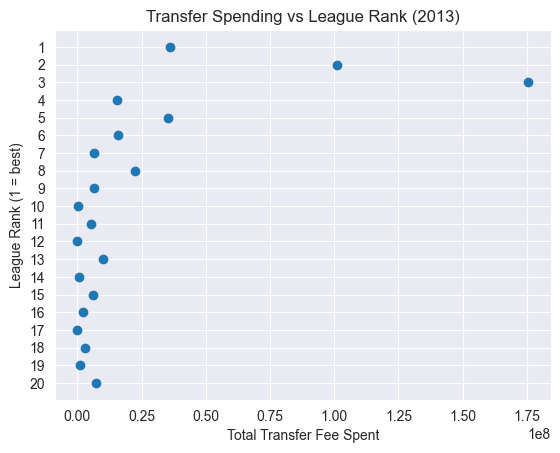

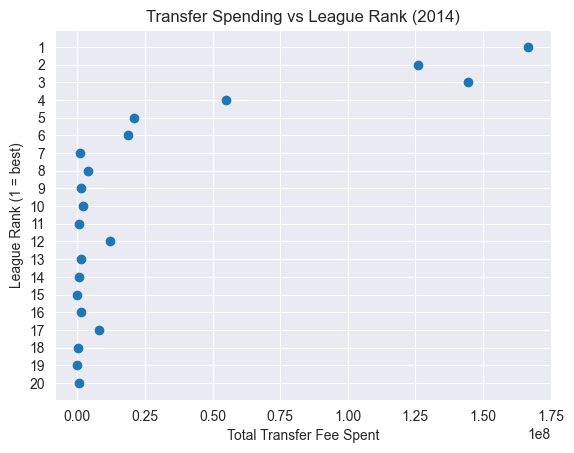

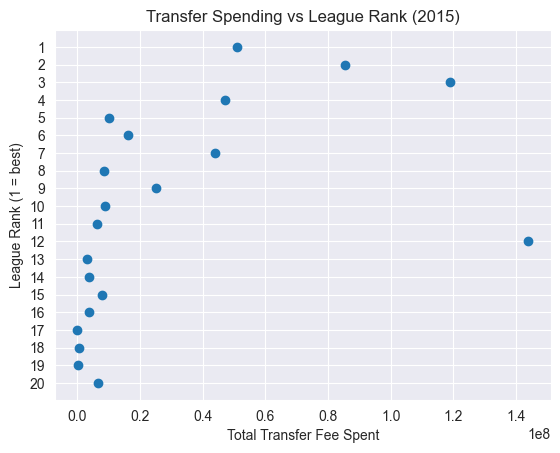

In [107]:
out_es['Rk'] = pd.to_numeric(out_es['Rk'], errors='coerce')
out_es_2014['Rk'] = pd.to_numeric(out_es_2014['Rk'], errors='coerce')
out_es_2015['Rk'] = pd.to_numeric(out_es_2015['Rk'], errors='coerce')

# 2013
plt.scatter(out_es['total_transfer_fee'], out_es['Rk'])
plt.xlabel('Total Transfer Fee Spent')
plt.ylabel('League Rank (1 = best)')
plt.title('Transfer Spending vs League Rank (2013)')
plt.gca().invert_yaxis()

plt.yticks(np.arange(out_es['Rk'].min(), out_es['Rk'].max() + 1, 1))
plt.show()

# 2014
plt.scatter(out_es_2014['total_transfer_fee'], out_es_2014['Rk'])
plt.xlabel('Total Transfer Fee Spent')
plt.ylabel('League Rank (1 = best)')
plt.title('Transfer Spending vs League Rank (2014)')
plt.gca().invert_yaxis()
plt.yticks(np.arange(out_es_2014['Rk'].min(), out_es_2014['Rk'].max() + 1, 1))
plt.show()

# 2015
plt.scatter(out_es_2015['total_transfer_fee'], out_es_2015['Rk'])
plt.xlabel('Total Transfer Fee Spent')
plt.ylabel('League Rank (1 = best)')
plt.title('Transfer Spending vs League Rank (2015)')
plt.gca().invert_yaxis()
plt.yticks(np.arange(out_es_2015['Rk'].min(), out_es_2015['Rk'].max() + 1, 1))
plt.show()

From the scatterplots of the highest Spanish league, we can observe a clear pattern: most of the time, three to four teams spend significantly more than the others. Teams with higher spending amounts also tend to finish in the top positions. The 2015 season seems to be an exception, as the highest-spending team ended up around 12th place. From a football perspective, the three top clubs that come to mind are Real Madrid, Barcelona, and Atlético Madrid. It makes sense that these are the clubs that consistently spend a lot of money on new players and usually finish near the top of the final standings. Later we will see in a interactive plot which teams tend to spend more.

#### Metrics to see relationship

We chose to use Spearman’s correlation since the values from different leagues are not directly comparable. Therefore, we focus on describing the observed relationships rather than comparing absolute values, while exercising caution in interpreting all the metrics.

This code computes the Spearman rank correlation between each club’s total transfer fees and their league ranking (Rk) across the 2013–2015 seasons. Using Spearman’s correlation makes sense because it evaluates monotonic relationships based on ranks rather than raw values ideal when the data may not be linear or normally distributed. It helps reveal whether higher-spending clubs tend to achieve better (lower) rankings. However, the method has limitations: it only measures rank-based association, not the magnitude of spending differences, and cannot capture non-monotonic or causal relationships.

In [108]:
datasets = [
    ('2013', out_es),
    ('2014', out_es_2014),
    ('2015', out_es_2015)
]

for year, data in datasets:
    corr, p_value = spearmanr(data['total_transfer_fee'], data['Rk'])
    print(f"--- {year} ---")
    print(f"Spearman correlation coefficient: {corr:.3f}")
    print(f"P-value: {p_value:.3e}\n")

--- 2013 ---
Spearman correlation coefficient: -0.729
P-value: 2.672e-04

--- 2014 ---
Spearman correlation coefficient: -0.811
P-value: 1.449e-05

--- 2015 ---
Spearman correlation coefficient: -0.802
P-value: 2.155e-05



The results show a negative correlation each year between total transfer spending and league ranking, that could indicate that clubs that spent more generally finished higher in the table. The correlations (-0.73 to -0.81) are statistically significant, suggesting a consistent relationship. However, this does not prove causation, high spending may correlate with success but isn’t necessarily the cause of it. Other factors like squad quality, management, or injuries could influence outcomes, and the limited sample size across seasons adds uncertainty to the strength and generalizability of these results.

#### Poisson Model season 2015

In [109]:
df = out_es_2015.dropna(subset=['Rk', 'total_transfer_fee']).copy()
df['Rk'] = pd.to_numeric(df['Rk'], errors='coerce')
df = df.dropna(subset=['Rk'])
df['log_spend'] = np.log1p(df['total_transfer_fee'])

model = smf.glm('Rk ~ log_spend', data=df, family=sm.families.Poisson()).fit()
print(model.summary())

coef = model.params['log_spend']
print(f"\nDoubling spending changes expected rank by a factor of {np.exp(coef*np.log(2)):.3f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     Rk   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -68.321
Date:                Fri, 07 Nov 2025   Deviance:                       56.954
Time:                        13:03:39   Pearson chi2:                     51.6
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5198
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1652      0.197     16.070      0.0

The model shows a significant negative relationship between transfer spending and league rank (p < 0.001), meaning teams that spend more tend to finish higher. Specifically, doubling spending improves expected rank by about 3.7%. The model explains roughly 52% of rank variation, though some overdispersion suggests results should be interpreted cautiously.

#### Premier League

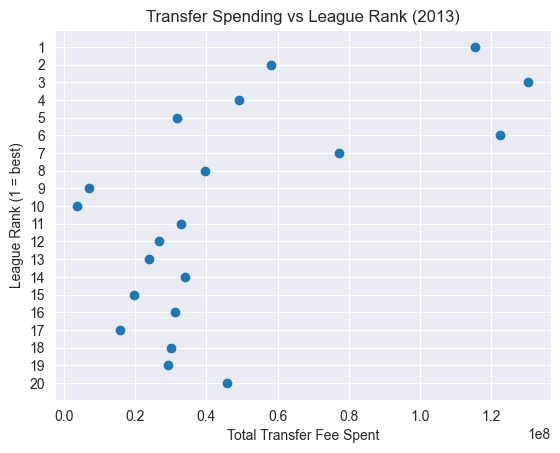

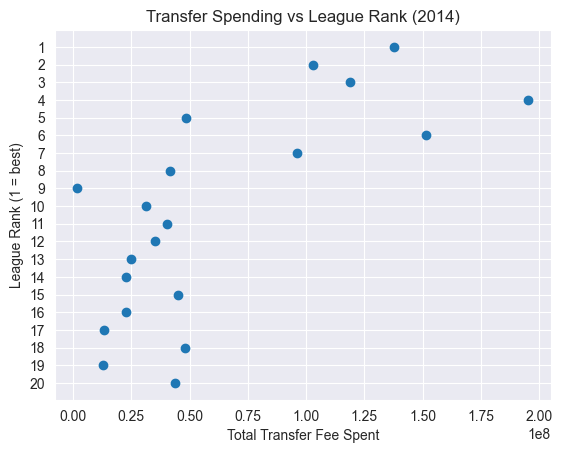

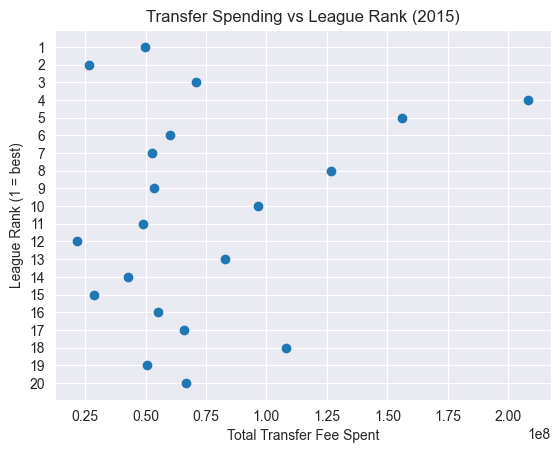

In [110]:
for df in [out_pl, out_pl_2014, out_pl_2015]:
    df['Rk'] = pd.to_numeric(df['Rk'], errors='coerce')

# 2013
plt.scatter(out_pl['total_transfer_fee'], out_pl['Rk'])
plt.xlabel('Total Transfer Fee Spent')
plt.ylabel('League Rank (1 = best)')
plt.title('Transfer Spending vs League Rank (2013)')
plt.gca().invert_yaxis()

# Set integer y-ticks
plt.yticks(np.arange(out_pl['Rk'].min(), out_pl['Rk'].max() + 1, 1))
plt.show()

# 2014
plt.scatter(out_pl_2014['total_transfer_fee'], out_pl_2014['Rk'])
plt.xlabel('Total Transfer Fee Spent')
plt.ylabel('League Rank (1 = best)')
plt.title('Transfer Spending vs League Rank (2014)')
plt.gca().invert_yaxis()
plt.yticks(np.arange(out_pl_2014['Rk'].min(), out_pl_2014['Rk'].max() + 1, 1))
plt.show()

# 2015
plt.scatter(out_pl_2015['total_transfer_fee'], out_pl_2015['Rk'])
plt.xlabel('Total Transfer Fee Spent')
plt.ylabel('League Rank (1 = best)')
plt.title('Transfer Spending vs League Rank (2015)')
plt.gca().invert_yaxis()
plt.yticks(np.arange(out_pl_2015['Rk'].min(), out_pl_2015['Rk'].max() + 1, 1))
plt.show()

We should always be careful when comparing plots from different datasets. However, the first intuition we get from the Premier League plots is that the points are more scattered, and there is no clear indication that the clubs spending the most money consistently finish at the top, at least in the three seasons shown above. What we can say is that, compared to the Spanish league, the Premier League has more clubs that spend large amounts of money, rather than just four dominant teams as in Spain. Overall, the patterns differ between the two leagues.

In [111]:
datasets = [
    ('2013', out_pl),
    ('2014', out_pl_2014),
    ('2015', out_pl_2015)
]

for year, data in datasets:
    corr, p_value = spearmanr(data['total_transfer_fee'], data['Rk'])
    print(f"--- {year} ---")
    print(f"Spearman correlation coefficient: {corr:.3f}")
    print(f"P-value: {p_value:.3e}\n")

--- 2013 ---
Spearman correlation coefficient: -0.574
P-value: 8.073e-03

--- 2014 ---
Spearman correlation coefficient: -0.671
P-value: 1.210e-03

--- 2015 ---
Spearman correlation coefficient: -0.068
P-value: 7.768e-01



The results show that the relationship between total transfer spending and league ranking varies across seasons. In 2013 and 2014, there is a moderate to strong negative correlation (Spearman’s ρ = -0.57 and -0.67, respectively), both statistically, indicating that clubs spending more tended to finish higher in the table. However, in 2015, the correlation is very weak and not statistically significant (ρ = -0.07, p = 0.78), suggesting no clear relationship that year (Outlier Leicester City).

Overall, while higher spending appears associated with better league performance in some seasons, this pattern is not consistent over time. The results do not imply causation success may coincide with high spending but could also depend on factors such as squad quality, management, or injuries. The limited sample size further adds uncertainty to the strength and generalizability of these findings.

In [112]:
df = out_pl_2015.dropna(subset=['Rk', 'total_transfer_fee']).copy()
df['Rk'] = pd.to_numeric(df['Rk'], errors='coerce')
df = df.dropna(subset=['Rk'])
df['log_spend'] = np.log1p(df['total_transfer_fee'])

model = smf.glm('Rk ~ log_spend', data=df, family=sm.families.Poisson()).fit()
print(model.summary())

coef = model.params['log_spend']
print(f"\nDoubling spending changes expected rank by a factor of {np.exp(coef*np.log(2)):.3f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     Rk   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -75.083
Date:                Fri, 07 Nov 2025   Deviance:                       70.479
Time:                        13:03:39   Pearson chi2:                     62.3
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05575
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7476      2.241      2.118      0.0

This model finds no statistically significant relationship between spending and rank (p = 0.285). While the coefficient suggests that doubling spending could improve expected rank by about 9%, the effect is too uncertain to be reliable. Overall, spending explains very little of rank variation.